In [1]:
import os
import time
import errno
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy import mean
from log_parser import log_parser
from mpl_toolkits.mplot3d import Axes3D

# Settings of Jupyter notebook HTML

In [2]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width: 100% !important; }</style>"))
display(HTML("<style>.container { font-size: 9.5px; !important; }</style>"))
display(HTML("<style>.rendered_html { font-size: 15px; color: red; }</style>"))
display(HTML("<style>.rendered_markdown { color: red; }</style>"))

# Initialization
### Pathes

In [3]:
default_file_name = 'dumpState.log'
file_name = 'G981V_TIE_3GMEM_30CPU_dumpstate_bottleneck_hint.txt'

#lp = log_parser('/home/ubuntu/Android/lisa_old/ipynb/performance/testingdata/dumpState_1593794288665.log')
lp = log_parser('/home/ubuntu/Android/lisa_old/ipynb/performance/testingdata/{}'.format(default_file_name))
ssrm = log_parser('/home/ubuntu/Android/lisa_old/ipynb/performance/testingdata/SSRM.log')

Reading /home/ubuntu/Android/lisa_old/ipynb/performance/testingdata/dumpState.log file is completed with 1210558 lines

Reading /home/ubuntu/Android/lisa_old/ipynb/performance/testingdata/SSRM.log file is completed with 7805 lines



### Values

In [4]:
pData1 = [
    'MEMORY INFO', 
    'MEMSIZE INFO', 
    'SERVICE CRITICAL cpuinfo',
    'SERVICE CRITICAL SurfaceFlinger',
    'compressed core&heap dump',
    'SYSTEM LOG',
    'EVENT LOG',
    'KERNEL LOG',
    'LAST KMSG',
    'AP RESET INFO',
    'FILESYSTEMS & FREE SPACE',
    'SERVICE content',
    'SERVICE dropbox',
    'SERVICE accessibility',
    'SERVICE batterystats',
    'SERVICE HIGH meminfo',
    'SERVICE package',
    'SERVICE binder_calls_stats',
    'SERVICE wifi',
    'SERVICE procstats',
    'OLOG',
    'ACTIVITY MANAGER MARs',
    'ACTIVITY MANAGER PENDING INTENTS',
    'ACTIVITY MANAGER BROADCAST STATE',
    'ACTIVITY MANAGER LMK KILLS',
    'STORAGE BUFFER',
    'SYSTEM PROPERTIES',
    'CPU INFO',
    'VM TRACES JUST NOW',
    'MMC blk0 error',
    'DUMP OF SERVICE connmetrics',
    'DUMP OF SERVICE gfxinfo',
    'DUMP OF SERVICE display',
    'DUMP OF SERVICE telephony.registry',
    'DUMP OF SERVICE wifiscanner',
    'DUMP OF SERVICE binder_calls_stats',
    'LOG STATISTICS',
    'TSP RAW DATA',
    'beginning of main',
    'STORAGED IO INFO',
    'SEC LOG',
]

lp.run(arg1=pData1)

#display(lp.log_sections)

### Functions

In [5]:
def grep(lines, searchers, n=99999, show=True):
    result = list()
    number_of_lines = 0
    number_of_negative_lines = 0
    negative_lines = list()

    if n < 0:
        number_of_negative_lines = (-1) * n
        
    for line in lines:
        if len(line) > 0:
            for searcher in searchers:
                if re.search(searcher, line):
                    if n >= 0:
                        number_of_lines = n
                    else:
                        for negative_line in negative_lines:
                            print(negative_line.strip())
                            result.append(negative_line.strip())
                        print(line)
                        result.append(line.strip())
                        
            if number_of_lines > 0:
                if show:
                    print(line.strip())
                result.append(line.strip())
                number_of_lines -= 1
                #if number_of_lines == 0:
                    #print("\n")
                    #result.append('')

            if number_of_negative_lines > 0:
                negative_lines.append(line)
                number_of_negative_lines -= 1
            elif n < 0:
                negative_lines.pop(0)
                negative_lines.append(line)
                
    if len(result) == 0:
        print("--- Nothing ---")
        
    return result

In [6]:
def pickedup(src, searcher, index=0):
    separators = ['/', ',', ' ']
    
    if searcher not in src:
        return None
    
    splited = src.split(searcher)
    if splited <= 0:
        return None
    
    numbers = re.findall('\d+', splited[1])
    if len(numbers) > index:
        return int(numbers[index])
    
    return None

In [7]:
def DictFromPickedUp(src, searchers):
    result = dict()
    for key in searchers.keys():
        result[key] = list()

    tmp = dict()
    for line in src:
        flag = False
        for key in searchers.keys():
            tmp[key] = pickedup(line, key, searchers[key])
            if tmp[key] is None:
                flag = True

        if flag == True:
            continue

        for key in searchers.keys():
            result[key].append(tmp[key])
            
    return result

In [8]:
def orderbyeq(src, index=0):
    result = dict()
    items = re.split('[ ]', src)
    for item in items:
        if '=' in item and item[0] == '[':
            item = item[1:]
            splited = item.split('=')
            key = splited[0]
            numbers = re.findall('\d+', splited[1])
            if numbers > 0:
                result[key] = int(numbers[0])
                
    return result

In [9]:
def DataframeFromDictSortByCount(rawdata):
    df = pd.DataFrame.from_dict(rawdata, orient='index')
    df['count'] = df.count(axis=1, numeric_only=True)
    df = df.sort_index(by='count', axis=0, ascending=False)
    df = df.drop(columns=['count'])    
    return df

In [10]:
def PlotFromDict(rawdata, threshold, title='', ylabel=''):
    df = pd.DataFrame.from_dict(rawdata, orient='index')
    for key in df.index:
        if max(rawdata[key]) > threshold:
            s = pd.Series(rawdata[key])
            ax = s.plot(figsize=(30,5), label=key, legend=True)
            ax.axhline(y=threshold, xmin=-1, xmax=1, color='r', linestyle='--', lw=2)
            ax.set_title(title)
            ax.set_ylabel(ylabel)

In [11]:
def MarkupLCDON(lines):
    LCD_ON = list()
    marker = ''
    for line in lines:
        if re.search('LCD', line):
            if re.search(' ON ', line):
                LCD_ON.append(line)
                marker = ' LCDON >>> '
                print(line)
            elif re.search(' OFF ', line):
                LCD_ON.append(line)
                marker = ''
                print(line)
        else:
            LCD_ON.append(marker + line)
            print(marker + line)
    return LCD_ON

In [12]:
def str2num(string):
    try:
        number = int(string)
    except:
        number = -1
        
    return number

def GetTime(line, type=None):
    Days = [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    splited_items = line.split(' ')
    Date = 0
    for item in splited_items:
        if Date == 0:
            if len(item) > 4 and item[-3] is '-':
                Month = str2num(item[-5:-3])
                Day = str2num(item[-2:])
                if Month >= 0 and Day >= 0 :
                    Date = (Month * Days[Month] + Day) * 24 * 60 * 60 * 1000
        else:
            if type is 'SSRM':
                item += '.000'

            if len(item) > 11 and item[2] is ':' and item[5] is ':' and item[8] is '.':
                Hour = str2num(item[0:2])
                Minute = str2num(item[3:5])
                Second = str2num(item[6:8])
                MiliSecond = str2num(item[9:12])
                if Hour >= 0 and Minute >= 0 and Second >= 0 and MiliSecond >= 0:
                    return Date + ((Hour * 60 + Minute) * 60 + Second) * 1000 + MiliSecond
            Date = 0
            
    return -1

def GetKernelTime(line):
    splited = line.split('[')
    splited = splited[1].split(']')
    splited = splited[0].split('.')

    second = str2num(splited[0])
    if second < 0:
        return -1
    
    nanosecond = str2num(splited[1])
    if nanosecond < 0:
        return -1
    
    return (int)(second * 1000 + (int)(nanosecond / 1000))

# <span style="color:blue">Base</span> 

In [13]:
lines = lp.log_sections['SERVICE content']
tmp = grep(lines,['Uptime'], 1)

Uptime: 3m11s


In [14]:
lines = lp.log_sections['DUMP OF SERVICE display']
tmp = grep(lines,['mDefaultViewport'], 1)

--- Nothing ---


In [15]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['dumpstate: begin', 'dumpstate: done', 'Dumpstate info: id', 'dumpstate: do_zip_file'], 1)

02-05 10:38:38.201  root  8452  8452 I dumpstate: do_zip_file: 0 do_vibrate: 0 use_socket: 1 use_control_socket: 0 do_screenshot: 0 is_remote_mode: 0 show_header_only: 0 do_start_service: 0 telephony_only: 0 wifi_only: 0 do_progress_updates: 0 fd: -1 bugreport_mode: BUGREPORT_DEFAULT dumpstate_hal_mode: DEFAULT limited_only: 0 args: /system/bin/dumpstate -s


* 16xxxxxx ns : 60 hz 
* 8xxxxxx ns : 120 hz

In [16]:
lines = lp.log_sections['compressed core&heap dump']
tmp = grep(lines,['VSYNC period'], 1)
lines = lp.log_sections['SERVICE CRITICAL SurfaceFlinger']
tmp = grep(lines,['VSYNC period'], 1)

--- Nothing ---
present offset:         0 ns	     VSYNC period:  16666666 ns


In [17]:
lines = lp.log_sections['DUMP OF SERVICE display']
tmp = grep(lines,['DisplayModeRecord'], 1)

DisplayModeRecord{mMode={id=1, width=1080, height=2400, fps=120.00001}}
DisplayModeRecord{mMode={id=2, width=1080, height=2400, fps=96.00001}}
DisplayModeRecord{mMode={id=3, width=1080, height=2400, fps=60.000004}}
DisplayModeRecord{mMode={id=4, width=1080, height=2400, fps=48.000004}}


It is possible to monitor the changing of screen resolution.

Size=1080x2400

In [18]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['setForcedDisplaySizeDensity'], 1)

--- Nothing ---


* the number of installed packages

In [19]:
lines = lp.log_sections['ACTIVITY MANAGER MARs']
tmp = grep(lines,['mManagedPackage'], 1)

--- Nothing ---


* debug level<br>
    high : 0x4948<br>
    mid : 0x494d<br>
    low : 0x4f4c

In [20]:
lines = lp.log_sections['SYSTEM PROPERTIES']
tmp = grep(lines,['debug_level'], 1)

[ro.boot.debug_level]: [0x4f4c]
[ro.debug_level]: [0x494d]
[ro.vendor.boot.debug_level]: [0x4f4c]


* Calculation for gap between android time and kernel time.

In [21]:
lines = lp.log_sections['KERNEL LOG']
sync_logs = grep(lines,['@Sync'], 1, show=True)

gapoftime = list()
for sync_log in sync_logs:
    androidtime = GetTime(sync_log)
    kerneltime = GetKernelTime(sync_log)

    if androidtime < 0 or kerneltime < 0:
        continue

    print("{} - {} = {}").format(androidtime, kerneltime, androidtime - kerneltime)
    gapoftime.append(androidtime - kerneltime)

GAP_OF_TIME = 0

if len(gapoftime) > 0:
    GAP_OF_TIME = int(mean(gapoftime) + 0.5)
    #display(gapoftime)
    display("Average : {}".format(GAP_OF_TIME))
    GAP_OF_TIME = gapoftime[0]
    display("Current : {}".format(GAP_OF_TIME))   

<6>[   54.830487] [4:       watchdog: 1398] !@Sync: 1 heap: 69 / 82 [2021-03-29 16:52:56.053] sdogWay: softdog
<6>[   84.830890] [6:       watchdog: 1398] !@Sync: 2 heap: 67 / 85 [2021-03-29 16:53:26.054] sdogWay: softdog
<6>[  114.831525] [4:       watchdog: 1398] !@Sync: 3 heap: 66 / 88 [2021-03-29 16:53:56.054] sdogWay: softdog
<6>[  144.832882] [5:       watchdog: 1398] !@Sync: 4 heap: 82 / 88 [2021-03-29 16:54:26.055] sdogWay: softdog
<6>[  174.835280] [4:       watchdog: 1398] !@Sync: 5 heap: 75 / 88 [2021-03-29 16:54:56.058] sdogWay: softdog
<6>[  204.836098] [5:       watchdog: 1398] !@Sync: 6 heap: 78 / 84 [2021-03-29 16:55:26.058] sdogWay: softdog
<6>[  234.838162] [4:       watchdog: 1398] !@Sync: 7 heap: 70 / 84 [2021-03-29 16:55:56.060] sdogWay: softdog
<6>[  264.838669] [4:       watchdog: 1398] !@Sync: 8 heap: 82 / 89 [2021-03-29 16:56:26.061] sdogWay: softdog
10601576053 - 54830 = 10601521223
10601606054 - 84830 = 10601521224
10601636054 - 114831 = 10601521223
106016660

'Average : 10601521223'

'Current : 10601521223'

# <span style="color:blue">CPU</span> 

The sampling time should be checked.
If the term is short, the cpu usage infor is not important.

* CPU frequency table and max frequency

In [22]:
lines = lp.log_sections['SERVICE batterystats']
CPU_freqs = grep(lines,['CPU freqs'], 1)
CPU_MAX_FREQ = 2000000

if len(CPU_freqs) > 0:
    CPU_MAX_FREQ = 0
    CPU_FREQ_TABLE = CPU_freqs[0].split(':')[1]
    for CPU_freq in CPU_FREQ_TABLE.split(' '):
        if len(CPU_freq) > 0:
            num_cpu_freq = int(CPU_freq)
            if num_cpu_freq > CPU_MAX_FREQ:
                CPU_MAX_FREQ = num_cpu_freq
    print('Max CPU Freq : ' + str(CPU_MAX_FREQ))

CPU freqs: 400000 533000 650000 754000 858000 962000 1066000 1170000 1274000 1378000 1482000 1586000 1690000 1794000 1898000 2002000 2106000 2210000 533000 624000 728000 832000 936000 1040000 1144000 1248000 1352000 1456000 1560000 1664000 1768000 1872000 1976000 2080000 2184000 2288000 2392000 2496000 2600000 2704000 2808000 533000 624000 728000 832000 936000 1040000 1144000 1248000 1352000 1456000 1560000 1664000 1768000 1872000 1976000 2080000 2184000 2288000 2392000 2496000 2600000 2704000 2808000 2912000
Max CPU Freq : 2912000


In [23]:
display(lp.log_sections['SERVICE CRITICAL cpuinfo'][:15])

['DUMP OF SERVICE CRITICAL cpuinfo:\n',
 'Load: 18.1 / 11.11 / 4.55\n',
 'CPU usage from 177923ms to 68419ms ago (2021-03-29 16:53:34.163 to 2021-03-29 16:55:23.667):\n',
 '  34% 1331/system_server: 21% user + 12% kernel / faults: 366397 minor 9517 major\n',
 '  8.8% 136/kswapd0: 0% user + 8.8% kernel\n',
 '  4.7% 960/surfaceflinger: 2.4% user + 2.2% kernel / faults: 1379 minor 1318 major\n',
 '  3.7% 14198/com.facebook.katana: 2.5% user + 1.1% kernel / faults: 27523 minor 1582 major\n',
 '  3.5% 10853/com.android.settings: 2.3% user + 1.2% kernel / faults: 31178 minor 813 major\n',
 '  3.2% 838/statsd: 2.8% user + 0.3% kernel / faults: 1605 minor 120 major\n',
 '  3.1% 2734/com.google.android.gms.persistent: 1.9% user + 1.1% kernel / faults: 29654 minor 1925 major\n',
 '  2.2% 6557/com.samsung.android.honeyboard: 1.6% user + 0.5% kernel / faults: 37443 minor 4392 major\n',
 '  2.1% 1760/com.android.phone: 1.5% user + 0.5% kernel / faults: 33286 minor 1148 major\n',
 '  2.1% 1796/com.a

In [24]:
lines = lp.log_sections['CPU INFO']
CPU_freqs = grep(lines,['Threads'], 25)

Threads: 4302 total,   3 running, 4299 sleeping,   0 stopped,   0 zombie
Mem:  7360236K total,  6801588K used,   558648K free,   3739648 buffers
Swap:  4194300K total,  1048832K used,  3145468K free,  2455332K cached
800%cpu 110%user   0%nice  84%sys 594%idle   0%iow   4%irq   8%sirq   0%host
PID   TID USER         PR  NI[%CPU]S VIRT  RES PCY CMD             NAME
22088 22146 u0_a301      20   0  105 R  17G 152M  bg Thread-14       com.kt.giftbox.samsung
23820 23820 shell         0 -20 56.8 R  12G 7.9M  fg top             top
136   136 root         20   0 19.6 S    0    0  fg kswapd0         [kswapd0]
534   534 root         20   0  7.8 S  12G 4.5M  fg ueventd         ueventd
873  1607 system       20   0  1.9 S  12G 3.0M  fg usb@1.1-service android.hardware.usb@1.1-service.exynos2100
1331  1340 system       29   9  1.9 S  22G 499M  fg Jit thread pool system_server
589   589 root         10 -10  1.9 S  12G 1.6M  fg watchdogd       watchdogd
286   286 root         20   0  1.9 S    0    0 

# <span style="color:blue">[PACKAGES]</span> 

* Installed Packages and version.

In [25]:
lines = lp.log_sections['SERVICE package']
package_lines = grep(lines,['Package \[', 'versionName'], 1)

Package [com.google.android.networkstack.tethering] (9fc8311):
versionName=11-7069081
Package [com.samsung.android.provider.filterprovider] (992c76):
versionName=5.0.32
Package [com.sec.android.app.DataCreate] (4959edc):
versionName=1.1
Package [com.android.cts.priv.ctsshim] (6e3096b):
versionName=11-6508977
Package [com.samsung.android.smartswitchassistant] (6081277):
versionName=2.0.01
Package [com.sec.vsim.ericssonnsds.webapp] (1b4ed74):
versionName=2.0.06.0
Package [com.sec.android.app.setupwizardlegalprovider] (bf53ae3):
versionName=2.0.10.0
Package [com.elz.secondhandstore] (37c7e5e):
versionName=7.1.0
Package [com.google.android.youtube] (ebc8855):
versionName=16.11.35
Package [com.samsung.android.app.galaxyfinder] (7eff7f8):
versionName=9.7.09.0
Package [com.sec.location.nsflp2] (61a4ee4):
versionName=5.3.44
Package [com.samsung.android.themestore] (8ec94c2):
versionName=5.2.00.1215
Package [com.sec.android.app.chromecustomizations] (641cd09):
versionName=3.0.28
Package [com.sa

* Search the name of installed package and version.

In [26]:
tmp = grep(package_lines,['com.cashwalk.cashwalk'], 2)

--- Nothing ---


total 503 packages


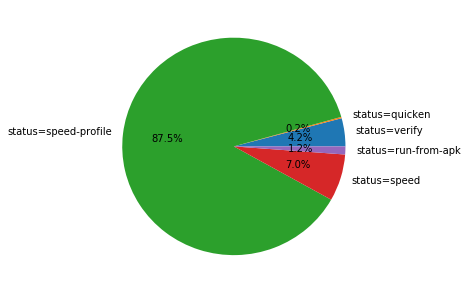

In [27]:
dexopt_lines = lp.log_sections['SERVICE package']
status_lines = grep(dexopt_lines,['status='], 1, show=False)

dexopt_state = dict()
for line in status_lines:
    if 'compilation_filter' in line:
        splited_line = line.split(',')
        status = splited_line[-1]
        dexopt_state[status] = dexopt_state.get(status, 0) + 1
    else:
        splited_line = line.split('[')
        if len(splited_line) > 0 and 'status' in splited_line[1]:         
            status = splited_line[1][:-2]
            dexopt_state[status] = dexopt_state.get(status, 0) + 1

#df.plot.pie(y='0', figsize=(5, 5), autopct='%1.1f%%', startangle=100)
print("total {} packages".format(len(status_lines)))
plt.figure(figsize=(5, 5))
plt.pie(dexopt_state.values(), labels = dexopt_state.keys(), autopct='%1.1f%%') 
plt.show() 

* kr.co.avad.diagnostictool app is used in A/S center.
* com.rsupport.rs.activity.rsupport.aas2 is remote service app.
* com.lguplus.mobile.smartcounsel is U+ customer service app.

In [28]:
lines = ssrm.file_lines
tmp = grep(lines,['kr.co.avad.diagnostictool', 'com.rsupport.rs.activity.rsupport.aas2', 'com.lguplus.mobile.smartcounsel'], 1)

2021-03-29 16:45:29 [PKG] kr.co.avad.diagnostictool
2021-03-29 16:49:55 [PKG] kr.co.avad.diagnostictool
2021-03-29 16:56:06 [PKG] kr.co.avad.diagnostictool


In [29]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['Choreographer: skipped'], 1)

--- Nothing ---


* Bad apps

: The PUBG game(com.tencent.ig) app have performance problem with LSI Ramen chip.

 4: name='Window{f7a5252 u0 com.autoclicker.clicker}', displayId=0, paused=false, hasFocus=false, hasWallpaper=false, visible=true, canReceiveKeys=false, flags=0x00000518, type=0x000007f6, samsungFlags=0x00000000, layer=121205, frame=[360,640][440,720], scale=1.000000, touchableRegion=[360,640][440,720], pTouchableRegion=<empty>, inputFeatures=0x00000000, ownerPid=2763, ownerUid=10837, dispatchingTimeout=5000.000ms

: The reddit app have a sluggish problm when scrolling in the app.

: Alibaba app(com.alibaba.aliexpresshd') could remove a file of mediaprovider.

In [30]:
lines = ssrm.file_lines
com_lines = grep(lines,['com.cashwalk.cashwalk', 'com.tencent.ig', 'com.reddit.frontpage', 'com.alibaba.aliexpresshd'], 1, show=True)

--- Nothing ---


In [31]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['com.autoclicker.clicker'], 1)

--- Nothing ---


* Check apps

In [32]:
lines = ssrm.file_lines
pkg_lines = grep(lines, ['PKG'], 1, show=False)
tmp = grep(pkg_lines, ['com.dunamu.exchange'], 2, show=True)

--- Nothing ---


* Youtube known issue.<br>
b/155941392 [Youtube] Frequent GC operation and it causes sluggish on device

In [33]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['ImageManager: cannot preload image. Invalid dimensions given'], 1)

--- Nothing ---


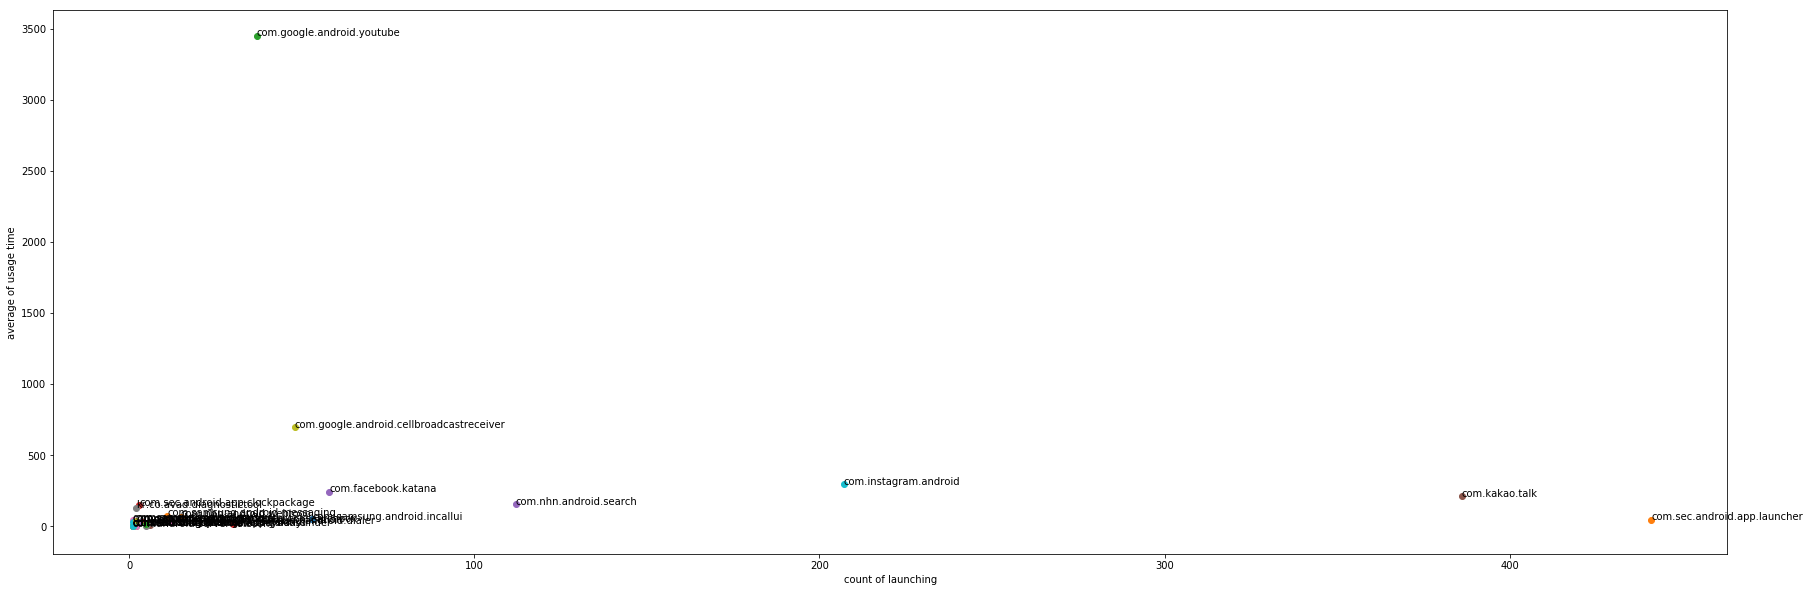

,count of launching,mean of usage time,median of usage time,status
com.sec.android.app.launcher,441,43,37,[status=speed-profile]
com.kakao.talk,386,209,14,[status=speed-profile]
com.instagram.android,207,295,24,[status=speed-profile]
com.nhn.android.search,112,155,18,[status=speed-profile]
com.facebook.katana,58,242,339,[status=speed-profile]
com.samsung.android.incallui,53,47,22,[status=speed]
com.google.android.cellbroadcastreceiver,48,695,339,[status=verify]
com.google.android.youtube,37,3451,30323,[status=speed-profile]
com.samsung.android.dialer,30,18,25,[status=speed-profile]
com.nhn.android.webtoon,15,65,92,[status=speed-profile]


In [34]:
lines = ssrm.file_lines
package_lines = grep(lines,['PKG', 'LCD'], 1, show=False)

packages_number = dict()
packages_runing_time = dict()

pre_time = 0

for package_line in package_lines:
    time = GetTime(package_line, 'SSRM')
    #print(time)
    if pre_time > 0:
        packages_number[pre_package][0] += 1
        if time > pre_time:
            packages_runing_time[pre_package].append((time - pre_time) / 1000)
        else:
            packages_runing_time[pre_package].append(0)
        
    if 'PKG' in package_line and 'OVHT_TYPE' not in package_line:
        package = package_line[26:]
        if ' ' in package:
            package = package.split(' ')[0]
        if not package in packages_number:
            packages_number[package] = [0]
            packages_runing_time[package] = list()
            
        pre_package = package
        pre_time = time


plt.figure(figsize=(30,10))

dexopt_lines = lp.log_sections['SERVICE package']
status_lines = grep(dexopt_lines,['status='], -2, show=False)


for package in packages_number:
    if packages_number[package][0] != 0:
        avg_launching = np.sum(packages_runing_time[package]) / packages_number[package][0]
    else:
        avg_launching = 0
    plt.text(packages_number[package][0], avg_launching, package)
    plt.scatter(packages_number[package][0], avg_launching)
    packages_number[package].append(avg_launching)

    if len(packages_runing_time[package]) > 0:
        median_launching = packages_runing_time[package][packages_number[package][0] / 2]
    else:
        median_launching = 0
    packages_number[package].append(median_launching)
    package_status = grep(status_lines,[package], 3, show=False)
    for line in package_status:
        if 'status=' in line:
            splited = line.split(' ')
            packages_number[package].append(splited[1])
            break
        

plt.xlabel('count of launching')
plt.ylabel('average of usage time')
#plt.xlim(0, 100)
plt.show()

df = pd.DataFrame.from_dict(packages_number, orient='index', columns=['count of launching', 'mean of usage time', 'median of usage time', 'status'])
df = df.sort_values(by=['count of launching'], ascending=False)
display(df.head(50))

# <span style="color:blue">[MEMORY]</span> 

In [35]:
meminfo_lines = lp.log_sections['SERVICE HIGH meminfo']
searchers = [': Native', ': System', ': Persistent', ': Persistent Service', ': Foreground', ': Visible', ': Perceptible', ': Perceptible Low', ': A Services', ': Previous', ': B Services', ': Picked', ': Seedbed', ': Cached']
High_meminfo = list()

for searcher in searchers:
    for meminfo_line in meminfo_lines:
        if searcher in meminfo_line:
            High_meminfo.append(meminfo_line)
            break
display(High_meminfo)

['  1,320,809K: Native\n',
 '    557,149K: System\n',
 '  1,952,810K: Persistent\n',
 '    293,548K: Persistent Service\n',
 '    219,124K: Foreground\n',
 '  2,450,940K: Visible\n',
 '    800,735K: Perceptible\n',
 '    220,716K: Perceptible Low\n',
 '    677,700K: A Services\n',
 '    529,361K: Previous\n',
 '  1,065,182K: B Services\n',
 '    941,985K: Picked\n',
 '  3,710,266K: Cached\n']

In [36]:
lines = lp.log_sections['SERVICE HIGH meminfo']
tmp = grep(lines,['Total PSS by process'], 5)
print('          :')
tmp = grep(lines,[': Picked'], 5)
print('          :')
tmp = grep(lines,[': Cached'], 10)
print('          :')
tmp = grep(lines,[': Perceptible'], 5)
print('          :')
tmp = grep(lines,[': Persistent'], 5)

Total PSS by process:
423,145K: system (pid 1331)                                            (   41,237K in swap)
279,200K: vendor.samsung.hardware.camera.provider@4.0-service_64 (pid 884) (    6,360K in swap)
187,453K: com.sec.android.app.launcher (pid 2124 / activities)         (   45,654K in swap)
173,114K: com.android.systemui (pid 1796)                              (   42,651K in swap)
          :
941,985K: Picked
199,399K: com.nhn.android.search (pid 19750)
179,118K: com.facebook.katana (pid 14198)
173,836K: com.google.android.youtube (pid 20285)
159,284K: com.android.vending (pid 19649)
369,081K: Picked                                                       (   87,965K in swap)
102,660K: com.nhn.android.search (pid 19750)                           (   18,087K in swap)
100,392K: com.facebook.katana (pid 14198)                              (   39,041K in swap)
68,830K: com.google.android.youtube (pid 20285)                       (    8,875K in swap)
50,812K: com.android.vending (pi

* If SwapFree was low, it should be checked.

SwapFree:           6432 kB

['------ MEMORY INFO (/proc/meminfo) ------\n',
 'MemTotal:        7360236 kB\n',
 'MemFree:         1183364 kB\n',
 'MemAvailable:    2746316 kB\n',
 'Buffers:            3336 kB\n',
 'Cached:          2224636 kB\n',
 'SwapCached:       114088 kB\n',
 'Active:          1843388 kB\n',
 'Inactive:        1960644 kB\n',
 'Active(anon):     958020 kB\n',
 'Inactive(anon):   864272 kB\n',
 'Active(file):     885368 kB\n',
 'Inactive(file):  1096372 kB\n',
 'Unevictable:        6564 kB\n',
 'Mlocked:            6564 kB\n',
 'RbinTotal:        804864 kB\n',
 'RbinAlloced:           0 kB\n',
 'RbinPool:              0 kB\n',
 'RbinFree:         571552 kB\n',
 'RbinCached:       233312 kB\n',
 'ZeroedFree:        44300 kB\n',
 'SwapTotal:       4194300 kB\n',
 'SwapFree:        3183612 kB\n']

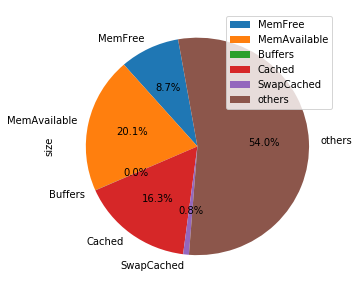

In [37]:
display(lp.log_sections['MEMORY INFO'][:23])

data = list()
sum = 0

for i in range(2,7):
    splited = lp.log_sections['MEMORY INFO'][i].split(':')
    size = int(splited[1].split('kB')[0])
    data.append([splited[0], size])
    sum += size

splited = lp.log_sections['MEMORY INFO'][1].split(':')
total = int(splited[1].split('kB')[0])
data.append(['others', total])

df = pd.DataFrame(data, columns=['id', 'size'])
df = df.set_index('id')

df.plot.pie(y='size',figsize=(5, 5), autopct='%1.1f%%', startangle=100)

plt.show()

In [38]:
lines = lp.log_sections['EVENT LOG']
killinfos = grep(lines,['killinfo'], 1)

03-29 16:56:15.380  lmkd   576   576 I killinfo: [19776,10237,999,850,117932,3,591352,2010732,1794180,108940,3640,10488,6368,804864,800584,312548,4280,4194300,3160572,1070644,838076,909136,875920,403532,71032,367048,72016,146028,0,0,444416,7504,143]
03-29 16:56:15.435  lmkd   576   576 I killinfo: [20098,10241,999,850,137256,3,589880,2003508,1794224,108896,3640,10488,6368,804864,800584,312548,4280,4194300,3167740,1073004,837684,915996,869452,403532,71032,366852,71632,145276,0,0,450560,7504,143]
03-29 16:56:15.473  lmkd   576   576 I killinfo: [20219,10165,999,850,87040,3,592168,2011088,1799912,108936,3656,10488,6564,804864,800584,312548,4280,4194300,3171580,1072696,835136,916388,874352,403532,71032,366852,71376,143772,0,0,450560,7000,143]
03-29 16:56:15.503  lmkd   576   576 I killinfo: [17173,10120,999,850,90648,3,587732,2009788,1803772,112496,3656,10488,6564,804864,800584,312548,4280,4194300,3173372,1072892,837096,916780,877096,403532,71032,366852,71120,143020,0,0,450560,6496,143]
03

In [39]:
lines = lp.log_sections['EVENT LOG']
am_app_dieds = grep(lines,['am_proc_died'], 1)

03-29 16:52:38.429  1000  1331  1887 I am_proc_died: [0,3386,com.samsung.android.bixby.agent,0,0,11,2237,2413]
03-29 16:52:41.808  1000  1331  1885 I am_proc_died: [0,1999,com.samsung.android.themecenter,0,0,10,2056,2559]
03-29 16:52:48.017  1000  1331  1880 I am_proc_died: [0,5941,com.samsung.android.aircommandmanager,16,0,11,1056,2638]
03-29 16:52:52.679  1000  1331  4690 I am_proc_died: [0,2898,com.sec.epdg,16,999,19,731,2696]
03-29 16:52:53.047  1000  1331  4682 I am_proc_died: [0,3034,com.google.android.cellbroadcastreceiver,16,999,19,655,2728]
03-29 16:52:53.158  1000  1331  1555 I am_proc_died: [0,3079,com.google.android.apps.carrier.carrierwifi,16,999,19,645,2734]
03-29 16:52:53.499  1000  1331  1555 I am_proc_died: [0,3301,com.samsung.android.accessibility.talkback,16,999,19,630,2758]
03-29 16:52:54.598  1000  1331  4743 I am_proc_died: [0,3486,com.samsung.android.game.gametools,16,999,19,480,2859]
03-29 16:52:55.006  1000  1331  1889 I am_proc_died: [0,3653,com.sec.android.ap

03-29 16:52:38.429  1000  1331  1887 I am_proc_died: [0,3386,com.samsung.android.bixby.agent,0,0,11,2237,2413]
03-29 16:52:41.808  1000  1331  1885 I am_proc_died: [0,1999,com.samsung.android.themecenter,0,0,10,2056,2559]
03-29 16:52:48.017  1000  1331  1880 I am_proc_died: [0,5941,com.samsung.android.aircommandmanager,16,0,11,1056,2638]


Text(0.5,1,'OOM ADJ(AM_PROC_DIED)')

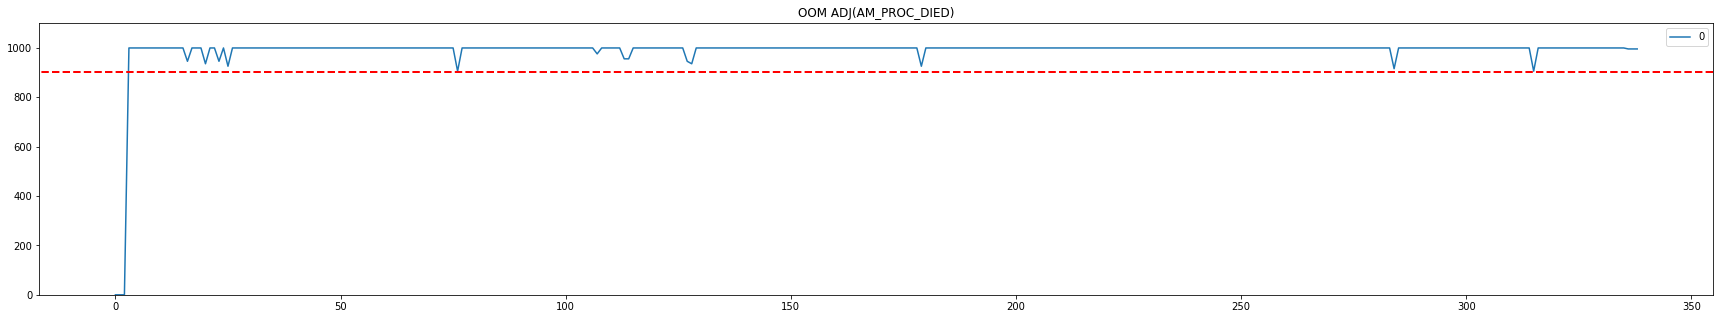

In [40]:
am_app_dieds_mem = list()
oom_adj = 0

for am_app_died in am_app_dieds:
    splited = am_app_died.split(',')
    pre_oom_adj = oom_adj
    oom_adj = int(splited[4])
    if oom_adj == 0 :
        oom_adj = pre_oom_adj
    am_app_dieds_mem.append(oom_adj)
    if oom_adj < 200 :
        print(am_app_died)
#print(am_app_dieds_mem)
df = pd.DataFrame(am_app_dieds_mem)
ax = df.plot(figsize=(30,5), ylim=(0, 1100))
ax.axhline(y=900, xmin=-1, xmax=1, color='r', linestyle='--', lw=2)
ax.set_title('OOM ADJ(AM_PROC_DIED)')

Text(0.5,1,'FREE MEMORY(AM_PROC_DIED)')

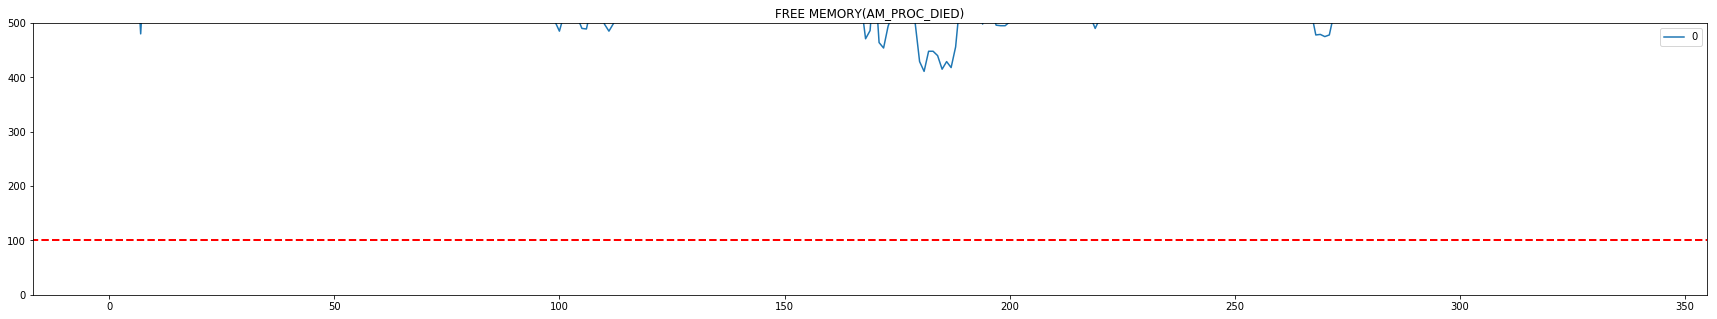

In [41]:
am_app_dieds_mem = list()

for am_app_died in am_app_dieds:
    splited = am_app_died.split(',')
    am_app_dieds_mem.append(int(splited[-2]))
#print(am_app_dieds_mem)
df = pd.DataFrame(am_app_dieds_mem)
ax = df.plot(figsize=(30,5), ylim=(0,500))
ax.axhline(y=100, xmin=-1, xmax=1, color='r', linestyle='--', lw=2)
ax.set_title('FREE MEMORY(AM_PROC_DIED)')

* If file cache size is smaller then 200, it can make some sluggish problem(in some scenario, likes take a picture with camera app).

Text(0.5,1,'FILE CACHE MEMORY(AM_PROC_DIED)')

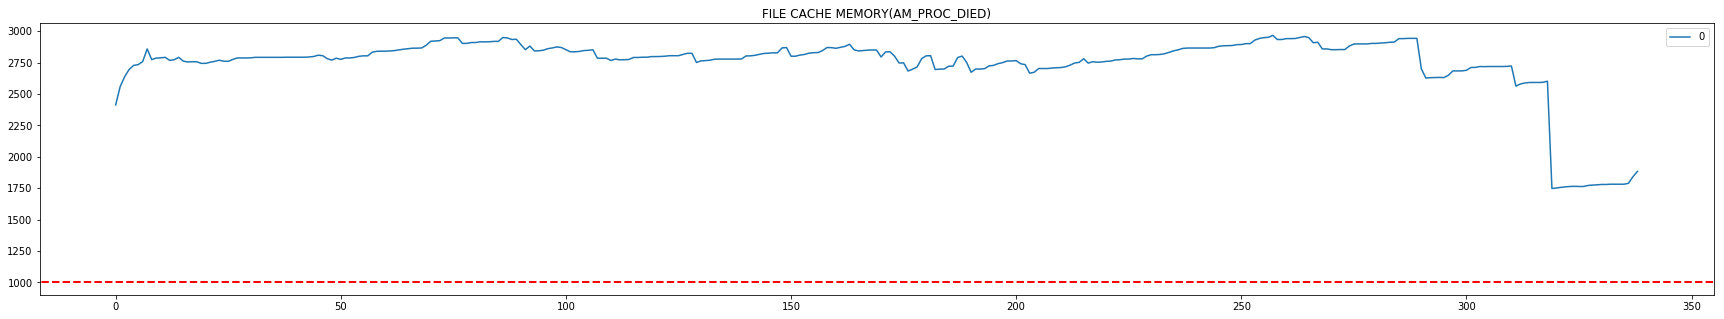

In [42]:
am_app_dieds_mem = list()

for am_app_died in am_app_dieds:
    splited = am_app_died.split(',')
    am_app_dieds_mem.append(int(splited[-1][:-1]))
#print(am_app_dieds_mem)
df = pd.DataFrame(am_app_dieds_mem)
ax = df.plot(figsize=(30,5))
ax.axhline(y=1000, xmin=-1, xmax=1, color='r', linestyle='--', lw=2)
ax.set_title('FILE CACHE MEMORY(AM_PROC_DIED)')

In [43]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['WaitForGcToComplete blocked', 'Waiting for a blocking GC Alloc'], 1)

03-29 16:52:44.129 10130  3582  3607 I droid.messagin: WaitForGcToComplete blocked ProfileSaver on ClassLinker for 49.607ms
03-29 16:52:44.223 10096  3621  3641 I msung.klmsagen: WaitForGcToComplete blocked ProfileSaver on AddRemoveAppImageSpace for 8.531ms
03-29 16:52:44.518 10112  3694  3713 I om.sec.spp.pus: WaitForGcToComplete blocked ProfileSaver on AddRemoveAppImageSpace for 24.721ms
03-29 16:52:44.529 10112  3694  3706 I om.sec.spp.pus: WaitForGcToComplete blocked RunEmptyCheckpoint on ProfileSaver for 10.774ms
03-29 16:52:44.768 10122  3719  3738 I .android.diale: WaitForGcToComplete blocked ProfileSaver on AddRemoveAppImageSpace for 115.919ms
03-29 16:52:47.791 10152  2124  5866 I id.app.launche: WaitForGcToComplete blocked ClassLinker on HeapTrim for 209.013ms
03-29 16:52:48.769 10236  5824  5869 I on.gearhead:ca: WaitForGcToComplete blocked ClassLinker on AddRemoveAppImageSpace for 294.160ms
03-29 16:52:50.307 10299  4517  4660 I com.ktshow.cs: WaitForGcToComplete blocked Pr

In [44]:
lines = lp.log_sections['EVENT LOG']
am_app_pss_lines = grep(lines,['am_pss', 'am_on_top_resumed_gained_called'], 1, show=False)

for am_app_pss_line in am_app_pss_lines:
    if 'am_pss' in am_app_pss_line:
        am_app_pss_line_splited = am_app_pss_line.split(',')
        if len(am_app_pss_line_splited) > 7:
            pss = am_app_pss_line_splited[-7]
            pss_MB = int(pss) / 1024 / 1024
            if (pss_MB > 50) :
                print(am_app_pss_line + "\t\t\t\t\t// PSS : " + str(pss_MB) + " MB  by " + am_app_pss_line_splited[2])
    else:
        print(am_app_pss_line)

03-29 16:52:39.815  1000  1331  1402 I am_pss  : [3380,10241,com.google.android.gms,111281152,79093760,0,275447808,2,10,3]					// PSS : 106 MB  by com.google.android.gms
03-29 16:52:39.825  1000  1331  1402 I am_pss  : [2734,10241,com.google.android.gms.persistent,53989376,26177536,0,208568320,2,10,10]					// PSS : 51 MB  by com.google.android.gms.persistent
03-29 16:52:39.973  1000  1331  1402 I am_pss  : [2304,1000,com.sec.imsservice,53941248,48422912,0,195776512,2,0,9]					// PSS : 51 MB  by com.sec.imsservice
03-29 16:52:40.026  1000  1331  1402 I am_pss  : [1796,10062,com.android.systemui,294244352,270016512,0,481255424,2,1,5]					// PSS : 280 MB  by com.android.systemui
03-29 16:52:40.040  1000  1331  1402 I am_pss  : [1760,1001,com.android.phone,111269888,87980032,0,292960256,2,1,13]					// PSS : 106 MB  by com.android.phone
03-29 16:52:40.049  1000  1331  1402 I am_pss  : [1331,1000,system,326978560,310972416,0,502685696,2,0,7]					// PSS : 311 MB  by system
03-29 16:53:00.549 

In [45]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['Couldn\'t load memtrack module', 'failed to get memory consumption'], 1)

03-29 16:53:27.868 10062  1796 13384 E memtrack: Couldn't load memtrack module
03-29 16:57:08.828 10241  3380 23092 E memtrack: Couldn't load memtrack module
03-29 16:57:34.955 10241  2734 25043 E memtrack: Couldn't load memtrack module
03-29 16:58:06.298 10241 10637 25509 E memtrack: Couldn't load memtrack module


* If heap free size is 0%, it doubts a memory leak problem.

In [46]:
lines = lp.log_sections['VM TRACES JUST NOW']
heap_lines = grep(lines,['Cmd line:', 'Heap:', 'Total GC', 'Total blocking GC'], 1, show=False)

printable = list()
flag_print = False
for heap_line in heap_lines:
    if 'Cmd line:' in heap_line:
        if flag_print:
            display(printable)
            flag_print = False
        del printable[:]
    printable.append(heap_line)
    if 'Total GC count' in heap_line and re.search('[1-9][0-9][0-9][0-9][0-9]', heap_line):
        flag_print = True
    if 'Heap:' in heap_line and re.search(' [0-9]%', heap_line):
        flag_print = True

['Cmd line: system_server',
 'Heap: 3% free, 86MB/89MB; 1668021 objects',
 'Total GC count: 86',
 'Total GC time: 12.625s',
 'Total blocking GC count: 5',
 'Total blocking GC time: 6.027s']

['Cmd line: com.google.android.gms.persistent',
 'Heap: 7% free, 23MB/25MB; 444128 objects',
 'Total GC count: 35',
 'Total GC time: 1.694s',
 'Total blocking GC count: 0',
 'Total blocking GC time: 0']

['Cmd line: com.google.android.gms',
 'Heap: 2% free, 22MB/22MB; 370357 objects',
 'Total GC count: 16',
 'Total GC time: 566.477ms',
 'Total blocking GC count: 0',
 'Total blocking GC time: 0']

['Cmd line: com.google.android.providers.media.module',
 'Heap: 6% free, 8272KB/8864KB; 86195 objects',
 'Total GC count: 20',
 'Total GC time: 274.191ms',
 'Total blocking GC count: 0',
 'Total blocking GC time: 0']

['Cmd line: kr.co.avad.diagnostictool',
 'Heap: 7% free, 25MB/27MB; 848829 objects',
 'Total GC count: 9',
 'Total GC time: 435.548ms',
 'Total blocking GC count: 0',
 'Total blocking GC time: 0']

['Cmd line: com.google.android.youtube',
 'Heap: 5% free, 5681KB/6007KB; 123229 objects',
 'Total GC count: 2',
 'Total GC time: 555.224ms',
 'Total blocking GC count: 1',
 'Total blocking GC time: 199.692ms']

['Cmd line: com.samsung.android.MtpApplication',
 'Heap: 3% free, 3710KB/3857KB; 108976 objects',
 'Total GC count: 2',
 'Total GC time: 34.694ms',
 'Total blocking GC count: 1',
 'Total blocking GC time: 12.921ms']

In [47]:
lines = lp.log_sections['LOG STATISTICS']
tmp = grep(lines,['ring buffer is'], 1)

main: ring buffer is 5 MiB (4 MiB consumed), max entry is 5120 B, max payload is 4068 B
radio: ring buffer is 512 KiB (303 KiB consumed), max entry is 5120 B, max payload is 4068 B
events: ring buffer is 256 KiB (255 KiB consumed), max entry is 5120 B, max payload is 4068 B
system: ring buffer is 2 MiB (1 MiB consumed), max entry is 5120 B, max payload is 4068 B
crash: ring buffer is 256 KiB (0 B consumed), max entry is 5120 B, max payload is 4068 B
stats: ring buffer is 64 KiB (0 B consumed), max entry is 5120 B, max payload is 4068 B
security: ring buffer is 256 KiB (0 B consumed), max entry is 5120 B, max payload is 4068 B
kernel: ring buffer is 256 KiB (0 B consumed), max entry is 5120 B, max payload is 4068 B


* Delay of ION allocation for Camera (100 < duration < 250)

In [48]:
lines = lp.log_sections['SYSTEM LOG']
ION_allocation_lines = grep(lines,['DEBUG:duration time'], 1, show=False)
for ION_allocation_line in ION_allocation_lines:
    if re.search('[0-9][0-9][0-9] msec', ION_allocation_line) or re.search('[0-9][0-9][0-9][0-9] msec', ION_allocation_line):
        print(ION_allocation_line)

03-29 16:52:26.092  1047   884  1043 I ExynosCameraInterface: DEBUG:duration time( 1635 msec):(init_func)
03-29 16:56:10.403  1047   884 22434 I ExynosCameraSec: DEBUG:duration time(  139 msec):(m_vplPreloadThreadFunc)
03-29 16:56:10.410  1047   884 22462 I ExynosCameraSec: DEBUG:duration time(  108 msec):(m_frameFactoryCreateThreadFunc)
03-29 16:56:10.428  1047   884   884 I ExynosCameraInterface: DEBUG:duration time(  129 msec):(HAL3_camera_device_configure_streams)
03-29 16:56:12.672  1047   884   884 I ExynosCameraInterface: DEBUG:duration time(  133 msec):(HAL3_camera_device_flush)
03-29 16:56:13.070  1047   884 22583 I ExynosCameraSec: DEBUG:duration time(  225 msec):(m_captureThreadFunc)
03-29 16:56:13.318  1047   884 22642 I ExynosCameraSec: DEBUG:duration time(  120 msec):(m_frameFactoryCreateThreadFunc)
03-29 16:56:13.333  1047   884   884 I ExynosCameraInterface: DEBUG:duration time(  138 msec):(HAL3_camera_device_configure_streams)
03-29 16:56:13.664  1047   884 22747 I Exy

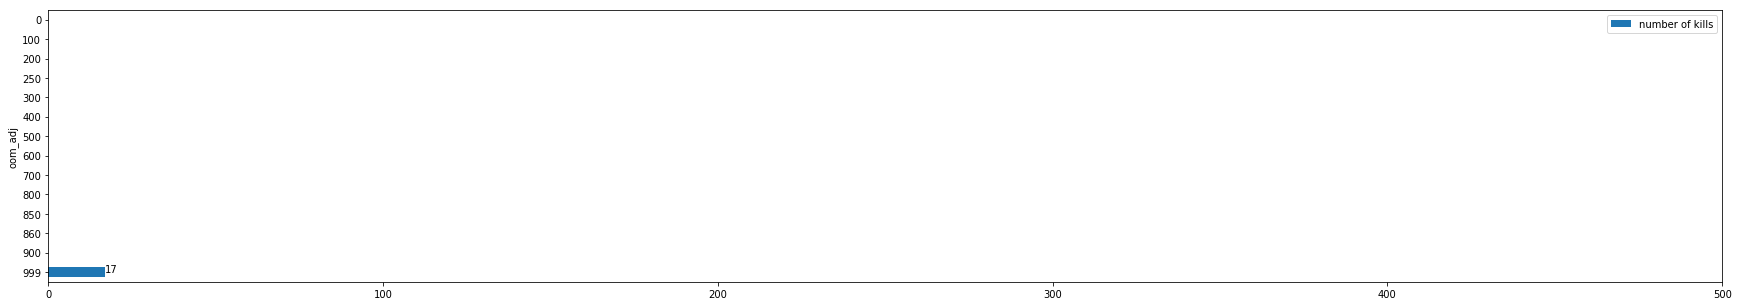

In [49]:
lines = lp.log_sections['ACTIVITY MANAGER LMK KILLS']
oom_adj_lines = grep(lines,['oom_adj'], 1, show=False)

if len(oom_adj_lines) > 0:
    lmk_kills = dict()
    lmk_kills['oom_adj'] = list()
    lmk_kills['number of kills'] = list()

    for oom_adj_line in oom_adj_lines:
        splited = oom_adj_line.split(' ')
        lmk_kills['oom_adj'].append(int(splited[-2][:-1]))
        lmk_kills['number of kills'].append(int(splited[-1]))

    df = pd.DataFrame.from_dict(lmk_kills)
    df.set_index('oom_adj', inplace=True)
    #df.sort_index(ascending=False)

    ax = df.plot(kind='barh', figsize=(30,5), xlim=(0,500))
    for index, value in enumerate(df['number of kills']):
        if value > 0 and value < 500:
            ax.text(value, index, str(value))
    plt.show()

* HeapTaskDaemon

<6>[51056.032367] [4:pool-42-thread-: 2960] heaviest_task_rss:.mobile.pguidea(28116) size:375680KB, totalram_pages:6480004KB

In [50]:
lines = lp.log_sections['SEC LOG']
lines += lp.log_sections['KERNEL LOG']

tmp = grep(lines,['heaviest_task_rss'], 1, show=True)

--- Nothing ---


* heimdall

12-23 09:05:07.849  1000   875   925 I heimdall: recv_memcg_event:1254, receiving 661 node 1 level 4 for com.skt.skaf.l001mtm091 total 1 memcg_usage 4303790080

In [51]:
lines = lp.log_sections['SYSTEM LOG']

tmp = grep(lines,['memcg_usage'], 1, show=True)

03-29 16:52:33.802  1000   963  1002 I heimdall: recv_memcg_event:1254, receiving 49 node 0 level 0 for com.sec.imsservice total 1 memcg_usage 111206400
03-29 16:52:39.313  1000   963  1002 I heimdall: recv_memcg_event:1254, receiving 49 node 0 level 0 for com.sec.imsservice total 1 memcg_usage 32870400
03-29 16:53:52.204  1000   963  1002 I heimdall: recv_memcg_event:1254, receiving 548 node 0 level 0 for com.samsung.android.mdx.kit total 1 memcg_usage 69320704
03-29 16:53:55.591  1000   963  1002 I heimdall: recv_memcg_event:1254, receiving 548 node 0 level 0 for com.samsung.android.mdx.kit total 1 memcg_usage 51494912


* lmk kill reasons
    enum kill_reasons {
        NONE = -1, /* To denote no kill condition */
        PRESSURE_AFTER_KILL = 0,
        NOT_RESPONDING,
        LOW_SWAP_AND_THRASHING,
        LOW_MEM_AND_SWAP,
        LOW_MEM_AND_THRASHING,
        DIRECT_RECL_AND_THRASHING,
        LOW_MEM_AND_SWAP_UTIL,
        PRESSURE_AFTER_KILL_DRKILL,
        EMERGENCY_KILL,
        EMERGENCY_KILL_LOWCACHE,
        KILL_REASON_COUNT
    };


# <span style="color:blue">[PROCSTATS]</span>

* displayed format

PSS -  RSS - USS

In [52]:
lines = lp.log_sections['SERVICE procstats']
cur_lines = list()
flag = False
#display(lines)
for line in lines:
    if '*' in line:
        if flag:
            display(cur_lines)
            flag = False
        del cur_lines[:]
        cur_lines = list()
        cur_lines.append(line)
    elif 'over' in line:
        #numbers = re.findall('\d+', line)
        cur_lines.append(line)
        memory = re.findall('GB', line)
        if len(memory) > 0:
            flag = True

In [53]:
lines = lp.log_sections['SERVICE procstats']
cur_lines = list()
flag = False
#display(lines)
for line in lines:
    if '*' in line:
        if flag:
            display(cur_lines)
            flag = False
        del cur_lines[:]
        cur_lines = list()
        cur_lines.append(line)
    elif 'over' in line:
        #numbers = re.findall('\d+', line)
        cur_lines.append(line)
        memory = re.findall('[7-9][0-9][0-9]MB', line)
        if len(memory) > 0:
            flag = True

['  * com.nhn.android.search / u0a361 / v10320510:\n',
 '         TOTAL: 5.2% (297MB-405MB-643MB/272MB-374MB-602MB/446MB-554MB-795MB over 7)\n',
 '           Top: 5.2% (297MB-405MB-643MB/272MB-374MB-602MB/446MB-554MB-795MB over 7)\n',
 '    (Last Act): 2.8% (267MB-282MB-297MB/241MB-252MB-263MB/419MB-429MB-439MB over 2)\n',
 '      (Cached): 14% (203MB-244MB-295MB/171MB-199MB-256MB/349MB-360MB-431MB over 5)\n']

['  * com.instagram.android / u0a320 / v279996063:\n',
 '          SOff/Norm/   Service: 32MB-34MB-36MB/9.9MB-19MB-28MB/141MB-129MB-141MB over 9\n',
 '                    (Cch Emty): 31MB-34MB-44MB/5.9MB-22MB-38MB/131MB-130MB-142MB over 30\n',
 '                Mod/(Cch Emty): 33MB-33MB-33MB/9.6MB-9.6MB-9.6MB/118MB-118MB-118MB over 1\n',
 '           SOn/Norm/   Service: 29MB-34MB-37MB/9.6MB-23MB-28MB/126MB-136MB-141MB over 26\n',
 '                    (Cch Emty): 29MB-34MB-38MB/8.4MB-19MB-35MB/123MB-127MB-141MB over 30\n',
 '                Mod/   Service: 29MB-31MB-32MB/9.7MB-10MB-11MB/110MB-112MB-115MB over 2\n',
 '                    (Cch Emty): 29MB-32MB-35MB/9.3MB-13MB-27MB/123MB-120MB-140MB over 7\n',
 '          SOff/Norm/       Top: 175MB-329MB-494MB/131MB-277MB-407MB/296MB-442MB-571MB over 5\n',
 '                    (Last Act): 161MB-221MB-335MB/119MB-188MB-300MB/355MB-356MB-472MB over 5\n',
 '                     (Cch Act): 151MB-206MB-345MB/55MB-141MB-310MB/223MB-293MB-471

['  * com.nhn.android.search / u0a361 / v10320510:\n',
 '          SOff/Norm/       Top: 260MB-295MB-330MB/203MB-243MB-272MB/355MB-352MB-388MB over 6\n',
 '                    (Last Act): 243MB-270MB-290MB/225MB-250MB-270MB/338MB-364MB-385MB over 6\n',
 '                    (Cch CAct): 237MB-259MB-290MB/7.4MB-80MB-250MB/122MB-169MB-364MB over 9\n',
 '                Mod/(Cch CAct): 239MB-239MB-239MB/14MB-14MB-14MB/97MB-97MB-97MB over 1\n',
 '           SOn/Norm/    Imp Fg: 275MB-305MB-348MB/207MB-256MB-290MB/325MB-370MB-406MB over 13\n',
 '                    (Last Act): 272MB-291MB-312MB/199MB-240MB-269MB/385MB-351MB-385MB over 3\n',
 '                    (Cch CAct): 132MB-225MB-276MB/9.5MB-99MB-225MB/224MB-192MB-328MB over 12\n',
 '                    (Cch Emty): 107MB-109MB-113MB/93MB-96MB-100MB/215MB-210MB-215MB over 3\n',
 '                Mod/    Imp Fg: 134MB-246MB-307MB/117MB-207MB-286MB/304MB-321MB-400MB over 5\n',
 '                    (Last Act): 279MB-279MB-279MB/259MB-259M

['  * com.instagram.android / u0a320 / v279996063:\n',
 '         TOTAL: 19% (175MB-448MB-663MB/131MB-414MB-620MB/296MB-579MB-800MB over 35)\n',
 '           Top: 19% (175MB-448MB-663MB/131MB-414MB-620MB/296MB-579MB-800MB over 35)\n',
 '    (Last Act): 14% (151MB-213MB-537MB/94MB-180MB-483MB/287MB-346MB-661MB over 21)\n',
 '      (Cached): 64% (62MB-170MB-453MB/33MB-122MB-390MB/149MB-266MB-569MB over 66)\n']

['  * com.nhn.android.search / u0a361 / v10320510:\n',
 '         TOTAL: 9.3% (297MB-403MB-643MB/263MB-366MB-602MB/414MB-541MB-795MB over 31)\n',
 '           Top: 9.3% (297MB-403MB-643MB/263MB-366MB-602MB/414MB-541MB-795MB over 31)\n',
 '    (Last Act): 8.9% (267MB-296MB-308MB/241MB-264MB-282MB/419MB-440MB-457MB over 9)\n',
 '      (Cached): 30% (97MB-223MB-333MB/77MB-164MB-272MB/227MB-307MB-452MB over 30)\n']

['  * com.nhn.android.search / u0a361 / v10320510:\n',
 '          SOff/Norm/       Top: 260MB-260MB-260MB/241MB-241MB-241MB/355MB-355MB-355MB over 1\n',
 '                    (Last Act): 243MB-249MB-254MB/225MB-230MB-235MB/338MB-343MB-348MB over 2\n',
 '           SOn/Norm/(Cch CAct): 132MB-192MB-253MB/72MB-120MB-201MB/224MB-220MB-314MB over 5\n',
 '                    (Cch Emty): 107MB-109MB-113MB/93MB-96MB-100MB/215MB-210MB-215MB over 3\n',
 '                Mod/    Imp Fg: 134MB-210MB-292MB/117MB-187MB-263MB/304MB-307MB-393MB over 3\n',
 '        Cur time +1m59s338ms: 107MB-107MB-107MB/93MB-93MB-93MB/208MB-208MB-208MB over 2\n',
 '          SOff/Norm/       Top: 310MB-310MB-310MB/279MB-279MB-279MB/456MB-456MB-456MB over 1\n',
 '                    (Last Act): 267MB-282MB-297MB/241MB-252MB-263MB/419MB-429MB-439MB over 2\n',
 '           SOn/Norm/       Top: 358MB-358MB-358MB/325MB-325MB-325MB/505MB-505MB-505MB over 1\n',
 '                     (Cch Act): 203MB-244MB-295MB/171MB-199M

['  * com.nhn.android.search / u0a361 / v10320510:\n',
 '         TOTAL: 4.9% (297MB-405MB-643MB/272MB-374MB-602MB/446MB-554MB-795MB over 7)\n',
 '           Top: 4.8% (297MB-405MB-643MB/272MB-374MB-602MB/446MB-554MB-795MB over 7)\n',
 '    (Last Act): 2.5% (267MB-282MB-297MB/241MB-252MB-263MB/419MB-429MB-439MB over 2)\n',
 '      (Cached): 17% (97MB-168MB-295MB/77MB-137MB-256MB/227MB-280MB-431MB over 11)\n']

In [54]:
lines = lp.log_sections['SERVICE procstats']
cur_lines = list()
flag = False
#display(lines)
for line in lines:
    if '*' in line:
        if flag:
            display(cur_lines)
            flag = False
        del cur_lines[:]
        cur_lines = list()
        cur_lines.append(line)
    elif 'over' in line:
        #numbers = re.findall('\d+', line)
        cur_lines.append(line)
        memory = re.findall('[0-9].[0-9][0-9]GB', line)
        if len(memory) > 0:
            flag = True

# <span style="color:blue">[AP Reset]</span> 

* The behaviour of user, likes a term of reboot should be checked.
* MP : Force Reset
* KP : Kernel Panic
* DP : Kernel Watchdog
* PF_SR (PLATFORM_SILENT_RESET) : Force sending signal to reboot the device. In this case, the dropbox should include system_server_crash log, but this is not effect to the performance.  
* silent.sec : Automation Restart(Normal Operation)
* PF_EX (PLATFORM_EXCEPTION)
* PF_SF : Crash of surfaceflinger
* FOTA : multicmd

In [55]:
lines = lp.log_sections['AP RESET INFO']
tmp = grep(lines,['AP RESET INFO'])

------ AP RESET INFO EXTEND (/data/system/users/service/data/eRR.p) ------
2021-02-11 20:01:00+0900 |    ON    | NP    | G996NKSU1AUB8 / OFFSRC:: SUB_OFF SMPL_TOUT UVLOB / ONSRC:: JIGONB / RSTSTAT:: PINRESET RSVD31
12021-01-01 00:00:23+0900 | SHUTDOWN |       | REASON: [FactoryTest] powreset 0
2021-03-25 17:29:11+0900 |    ON    | NP    | G996NKSU1AUB8 / OFFSRC:: PWRHOLD / ONSRC:: PWRON / RSTSTAT:: PINRESET RSVD31
2021-03-25 17:29:48+0900 |  REBOOT  |       | REASON: TSS Activation (KTC)
2021-03-25 17:30:34+0900 |    ON    | RP    | G996NKSU1AUB8 / OFFSRC: - / ONSRC: PWRON / RSTSTAT: SWRESET
2021-03-25 20:10:15+0900 |  REBOOT  |       | REASON: recovery
2021-03-25 20:14:22+0900 |    ON    | RP    | G996NKSS2AUBB / OFFSRC: - / ONSRC: PWRON / RSTSTAT: SWRESET
2021-03-29 16:51:48+0900 |  REBOOT  |       | REASON: userrequested
2021-03-29 16:52:54+0900 |    ON    | RP    | G996NKSS2AUBB / OFFSRC: - / ONSRC: PWRON / RSTSTAT: SWRESET



# <span style="color:blue">CRASH</span> 

* In the case of fatal exception, data_app_crash should be confirmed togather.
* In the case of data_app_anr, app launch should be confirmed togather. 
* Crashlytics Exception could not effect to the performance.
* NPE by silent reset : Force sending signal to reboot the device. In this case, the dropbox should include system_server_crash log, but this is not effect to the performance.

In [56]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['FATAL EXCEPTION', 'Fatal signal'], 4)

--- Nothing ---


In [57]:
lines = lp.log_sections['SERVICE dropbox']
tmp = grep(lines,['system_app_anr', 'system_app_crash', 'data_app_crash', 'data_app_anr', 'system_app_native_crash', 'data_app_native_crash'], 2)

--- Nothing ---


In [58]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['Sending signal'], 1)

03-29 16:52:38.404  5018  3386  3386 I Process : Sending signal. PID: 3386 SIG: 9
03-29 16:52:41.785  1000  1999  1999 I Process : Sending signal. PID: 1999 SIG: 9
03-29 16:52:47.763  1000  5941  5941 I Process : Sending signal. PID: 5941 SIG: 9
03-29 16:53:06.775  1000  6264  6264 I Process : Sending signal. PID: 6264 SIG: 9
03-29 16:53:22.005 10086 11954 11954 I Process : Sending signal. PID: 11954 SIG: 9
03-29 16:53:27.428 10086 13047 13047 I Process : Sending signal. PID: 13047 SIG: 9
03-29 16:53:38.128 10086 15428 15428 I Process : Sending signal. PID: 15428 SIG: 9
03-29 16:53:52.012 10086 17457 17457 I Process : Sending signal. PID: 17457 SIG: 9
03-29 16:53:53.091 10086 17721 17721 I Process : Sending signal. PID: 17721 SIG: 9
03-29 16:53:54.993 10086 18060 18060 I Process : Sending signal. PID: 18060 SIG: 9
03-29 16:53:57.179 10086 18426 18426 I Process : Sending signal. PID: 18426 SIG: 9
03-29 16:53:58.605 10086 18806 18806 I Process : Sending signal. PID: 18806 SIG: 9
03-29 16

# <span style="color:blue">[FILESYSTEM]</span> 


* Check whether sdcard is inserted or not.
* Check the available space of media.(It should be remained over 10% at least)

In [59]:
lines = lp.log_sections['FILESYSTEMS & FREE SPACE']
filesystem_lines = grep(lines,['FILESYSTEMS & FREE SPACE'])

------ FILESYSTEMS & FREE SPACE (df) ------
Filesystem        1K-blocks     Used Available Use% Mounted on
/dev/block/dm-4     6399504  6374816      8304 100% /
tmpfs               2849140     1460   2847680   1% /dev
tmpfs               2849140        0   2849140   0% /mnt
/dev/block/sda25      28136      148     27336   1% /metadata
/dev/block/dm-5     1712984  1705160         0 100% /vendor
/dev/block/dm-6      751676   750596         0 100% /product
/dev/block/dm-7        4072      984      3008  25% /odm
/dev/block/dm-8     1091076    23964   1050728   3% /prism
/dev/block/dm-9       29668      308     28760   2% /optics
tmpfs               3277684        0   3277684   0% /apex
/dev/block/sda32      46280       24     45236   1% /omr
/dev/block/sda31     596544     6280    577976   2% /cache
/dev/block/sda21      51200    43324      7876  85% /keyrefuge
/dev/block/sda2       16040     3276     12356  21% /efs
/dev/block/sda33      46280       20     45240   1% /spu
/dev/block/dm-1

* Check external sdcard

In [60]:
tmp = grep(filesystem_lines, ['/storage/', '/mnt/asec/'], 1)

/dev/fuse         236345324 28965288 207248964  13% /storage/emulated


* Description.

Some applications ( TikTok , Google Photos, Amazon Shopping ) were installed in sdcard in the user's device.<br>
When user entered those apps, It could be delayed.<br>
Please move those apps to the internal sdcard.<br>

/dev/block/dm-7                  9600    83   9517    1% /mnt/asec/com.zhiliaoapp.musically-w19U2VUWNRRfS9yi<br>
/dev/block/dm-8                  4448    23   4425    1% /mnt/asec/com.google.android.apps.photos-u7BcCB7ySRx2Bd4O<br>
/dev/block/dm-10                 5232    35   5197    1% /mnt/asec/com.amazon.mShop.android.shopping-Hys1Miat8tY5nhTH<br>

If the problem will happen again, after treating those apps.<br>
A dumpstate collected by Samsung Members application has a limited buffer size.<br>
So, it may not include the issue that you mentioned.<br>
Please report the issue right after it happens and elaborate on it.<br>
For better analysis, we need the name of application that is related to the issue and the time when it happens.

* If mmcqd process is found many times, it is possible that filesystem made a problem.

In [61]:
lines = ssrm.file_lines
TOP_lines = grep(lines,['TOP'], 1, show=False)
TOP_lines = grep(TOP_lines,['mmc'], 1)

--- Nothing ---


* Answer for PLM

The internal storage is 99% full, which have been causing unexpected delay when some apps access the storage.<br>
Please make enough free space on the internal storage. 10% free space is recommended.

After taking guided measures, if you face sluggishness again, report the issue right after it happens and elaborate on it.<br>
For better analysis, we need the name of application that is related to the issue and the time when it happens. 

------ FILESYSTEMS & FREE SPACE (df) ------<br>
Filesystem                     1K-blocks     Used Available Use% Mounted on<br>
/dev/block/dm-0                 26189072 25688192    492688  99%   13%  4096 /data

* SD card insert/remove

[119612.122688] [    kworker/3:2, 14008] mmc0: new ultra high speed SDR104 SDXC card at address 59b4<br>
[119612.132593] [    kworker/3:2, 14008] mmcblk0: mmc0:59b4 USDU1 59.8 GiB

In [62]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['card at address'], 1)

--- Nothing ---


In [63]:
lines = lp.log_sections['STORAGE BUFFER']
tmp = grep(lines,['insertion detected'], 1)

--- Nothing ---


* SD card error

<3>[855725.987054]  [6:   kworker/6:1H:  337] mmc0: Card stuck in wrong state! mmcblk0 card_busy_detect status: 0xf00<br>
<3>[855729.375238]  [6:   kworker/6:1H:  337] Buffer I/O error on dev mmcblk0p1, logical block 3848, lost async page write<br>
<3>[50825.096294]  [0:   kworker/0:2H:11790] mmcblk0: recovery failed!

In [64]:
lines = lp.log_sections['KERNEL LOG']
lines += lp.log_sections['LAST KMSG']
tmp = grep(lines,['card_busy_detect', 'Buffer I/O error', 'Card stuck in wrong state', 'recovery failed', 'mmc_rescan'], 1)

--- Nothing ---


* history of MMC blk0 error

If the count is under 100, it could be happenning during lcd on/off.

In [65]:
lines = lp.log_sections['MMC blk0 error']
display(lines)

[]

09-02 18:58:51.879  root   590 19806 E vold    : exfat -> Filesystem check failed (unknown exit code 8)<br>
09-02 18:58:51.879  root   590 19806 E vold    : public:179,1 failed filesystem check

In [66]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['Filesystem check failed', 'failed filesystem check'], 1)

--- Nothing ---


In [67]:
lines = lp.log_sections['STORAGED IO INFO']
#display(lines)
read_write = list()
for line in lines:
    splited_line = line.replace('\n', '').split(' ')
    if len(splited_line) > 0 and '.' in splited_line[0]:
        read_write.append(splited_line)
        #print(splited_line)
#tmp = grep(lines,['Filesystem check failed', 'failed filesystem check'], 1)
print(lines[1].replace('\n', '').split(' '))
io_df = pd.DataFrame(read_write, columns=lines[1].replace('\n', '').split(' '))
io_df = io_df.set_index('name/uid')
io_df = io_df.astype(int)

['name/uid', 'fg_rchar', 'fg_wchar', 'fg_rbytes', 'fg_wbytes', 'bg_rchar', 'bg_wchar', 'bg_rbytes', 'bg_wbytes', 'fg_fsync', 'bg_fsync']


In [68]:
io_df.sort_values(by=['fg_rchar'], ascending=False).head()

,fg_rchar,fg_wchar,fg_rbytes,fg_wbytes,bg_rchar,bg_wchar,bg_rbytes,bg_wbytes,fg_fsync,bg_fsync
name/uid,,,,,,,,,,
shared:android.uid.system,1376942492,239651398,2024112128,252440576,0,0,0,0,2575,0
com.google.android.providers.media.module,99093471,73399402,31035392,74416128,0,0,0,0,10,0
shared:android.uid.phone,93730221,4875694,169840640,6111232,0,0,0,0,43,0
shared:android.uid.systemui,60861170,7105437,210931712,6008832,0,0,0,0,37,0
com.ktcs.whowho,54788663,67193,81494016,647168,84902879,297170,115761152,1712128,5,84


In [69]:
io_df.sort_values(by=['fg_wchar'], ascending=False).head()

,fg_rchar,fg_wchar,fg_rbytes,fg_wbytes,bg_rchar,bg_wchar,bg_rbytes,bg_wbytes,fg_fsync,bg_fsync
name/uid,,,,,,,,,,
shared:android.uid.system,1376942492,239651398,2024112128,252440576,0,0,0,0,2575,0
com.google.android.providers.media.module,99093471,73399402,31035392,74416128,0,0,0,0,10,0
com.sec.android.app.launcher,42342049,11447723,59973632,11935744,17951183,638703,19394560,696320,34,8
shared:android.uid.systemui,60861170,7105437,210931712,6008832,0,0,0,0,37,0
shared:android.uid.phone,93730221,4875694,169840640,6111232,0,0,0,0,43,0


In [70]:
io_df.sort_values(by=['fg_rbytes'], ascending=False).head()

,fg_rchar,fg_wchar,fg_rbytes,fg_wbytes,bg_rchar,bg_wchar,bg_rbytes,bg_wbytes,fg_fsync,bg_fsync
name/uid,,,,,,,,,,
shared:android.uid.system,1376942492,239651398,2024112128,252440576,0,0,0,0,2575,0
shared:android.uid.systemui,60861170,7105437,210931712,6008832,0,0,0,0,37,0
shared:android.uid.phone,93730221,4875694,169840640,6111232,0,0,0,0,43,0
com.kakao.talk,3240088,1046579,87937024,1318912,3935497,739401,17199104,917504,6,13
com.ktcs.whowho,54788663,67193,81494016,647168,84902879,297170,115761152,1712128,5,84


In [71]:
io_df.sort_values(by=['fg_wbytes'], ascending=False).head()

,fg_rchar,fg_wchar,fg_rbytes,fg_wbytes,bg_rchar,bg_wchar,bg_rbytes,bg_wbytes,fg_fsync,bg_fsync
name/uid,,,,,,,,,,
shared:android.uid.system,1376942492,239651398,2024112128,252440576,0,0,0,0,2575,0
com.google.android.providers.media.module,99093471,73399402,31035392,74416128,0,0,0,0,10,0
com.sec.android.app.launcher,42342049,11447723,59973632,11935744,17951183,638703,19394560,696320,34,8
shared:android.uid.phone,93730221,4875694,169840640,6111232,0,0,0,0,43,0
shared:android.uid.systemui,60861170,7105437,210931712,6008832,0,0,0,0,37,0


In [72]:
io_df.sort_values(by=['bg_rchar'], ascending=False).head()

,fg_rchar,fg_wchar,fg_rbytes,fg_wbytes,bg_rchar,bg_wchar,bg_rbytes,bg_wbytes,fg_fsync,bg_fsync
name/uid,,,,,,,,,,
com.kt.giftbox.samsung,22611157,1351622,10919936,1699840,2594371554,2894425,532926464,4063232,7,15
com.samsung.android.spay,37953177,4525838,49258496,4976640,2426253764,195478,580669440,53248,4,2
com.ktshow.cs,46847182,1558108,45096960,2306048,590440294,1582383,66428928,2154496,1,1
com.kt.olleh.servicemenu,27777199,213500,2535424,323584,586788133,253183,32161792,446464,0,0
shared:com.google.uid.shared,0,0,0,0,187620649,29075367,386252800,56520704,0,799


In [73]:
io_df.sort_values(by=['bg_wchar'], ascending=False).head()

,fg_rchar,fg_wchar,fg_rbytes,fg_wbytes,bg_rchar,bg_wchar,bg_rbytes,bg_wbytes,fg_fsync,bg_fsync
name/uid,,,,,,,,,,
shared:android.uid.shell,0,0,0,0,78385317,59071213,12046336,26181632,0,174
shared:com.google.uid.shared,0,0,0,0,187620649,29075367,386252800,56520704,0,799
com.google.android.googlequicksearchbox,451199,3519,57769984,0,24395912,6198466,171622400,8798208,0,132
com.facebook.katana,8060992,94453,43671552,475136,39061571,4991250,81920000,4968448,0,0
com.samsung.sree,0,0,0,0,1186141,4029252,19116032,5672960,0,60


In [74]:
io_df.sort_values(by=['bg_rbytes'], ascending=False).head()

,fg_rchar,fg_wchar,fg_rbytes,fg_wbytes,bg_rchar,bg_wchar,bg_rbytes,bg_wbytes,fg_fsync,bg_fsync
name/uid,,,,,,,,,,
com.samsung.android.spay,37953177,4525838,49258496,4976640,2426253764,195478,580669440,53248,4,2
com.kt.giftbox.samsung,22611157,1351622,10919936,1699840,2594371554,2894425,532926464,4063232,7,15
shared:com.google.uid.shared,0,0,0,0,187620649,29075367,386252800,56520704,0,799
com.google.android.googlequicksearchbox,451199,3519,57769984,0,24395912,6198466,171622400,8798208,0,132
shared:com.google.android.apps.maps,0,0,0,0,4801663,437397,135303168,1503232,0,29


In [75]:
io_df.sort_values(by=['bg_wbytes'], ascending=False).head()

,fg_rchar,fg_wchar,fg_rbytes,fg_wbytes,bg_rchar,bg_wchar,bg_rbytes,bg_wbytes,fg_fsync,bg_fsync
name/uid,,,,,,,,,,
shared:com.google.uid.shared,0,0,0,0,187620649,29075367,386252800,56520704,0,799
shared:android.uid.shell,0,0,0,0,78385317,59071213,12046336,26181632,0,174
com.google.android.googlequicksearchbox,451199,3519,57769984,0,24395912,6198466,171622400,8798208,0,132
com.android.vending,2753526,198214,35790848,315392,45684764,3742912,30072832,6148096,14,214
com.samsung.sree,0,0,0,0,1186141,4029252,19116032,5672960,0,60


In [76]:
lines = lp.log_sections['SYSTEM LOG']
olog_lines = grep(lines,['MEDIA_SCANNER_SCAN_FILE'], 1)

03-29 16:56:07.216 10266  3795 17059 I MediaProvider: Begin Intent { act=android.intent.action.MEDIA_SCANNER_SCAN_FILE dat=file:///storage/emulated/0/log/err/mobiledata_blockhistory.dat flg=0x1000010 cmp=com.google.android.providers.media.module/com.android.providers.media.MediaService }
03-29 16:56:07.235 10266  3795 17059 I MediaProvider: End Intent { act=android.intent.action.MEDIA_SCANNER_SCAN_FILE dat=file:///storage/emulated/0/log/err/mobiledata_blockhistory.dat flg=0x1000010 cmp=com.google.android.providers.media.module/com.android.providers.media.MediaService }
03-29 16:56:07.311 10266  3795 17059 I MediaProvider: Begin Intent { act=android.intent.action.MEDIA_SCANNER_SCAN_FILE dat=file:///storage/emulated/0/log/err/mobiledata_dns.dat flg=0x1000010 cmp=com.google.android.providers.media.module/com.android.providers.media.MediaService }
03-29 16:56:07.323 10266  3795 17059 I MediaProvider: End Intent { act=android.intent.action.MEDIA_SCANNER_SCAN_FILE dat=file:///storage/emulate

* If data block has crashed, verity-fec module recovery them and those error log is shown. If error logs are shown many times, it is data block problem. 

<4>[   49.337374]  [2:  kworker/u16:4:  210] device-mapper: verity-fec: 259:9: FEC 12820480: corrected 4078 errors<br>
<4>[   49.409845]  [5:  kworker/u16:7:  358] device-mapper: verity-fec: 259:9: FEC 12713984: corrected 4046 errors<br>
<4>[   49.415984]  [4:  kworker/u16:6:  212] device-mapper: verity-fec: 259:9: FEC 19410944: corrected 3959 errors<br>

In [77]:
lines = lp.log_sections['KERNEL LOG']
FEC_lines = grep(lines,['verity-fec'], 1)
 

--- Nothing ---


# <span style="color:blue">[APP LAUNCH TIME]</span> 

In [78]:
lines = lp.log_sections['EVENT LOG']
am_app_transitions = grep(lines,['am_app_transition'], 1)

03-29 16:52:42.973  1000  1331  1402 I am_app_transition: [com.samsung.android.app.telephonyui,com.samsung.android.app.telephonyui.carrierui.networkui.app.AllowDataConnectionDialogActivity,WINDOWS_DRAWN,5538,-1,-1,390,WARM,speed]
03-29 16:52:54.048  1000  1331  1402 I am_app_transition: [com.sec.android.app.launcher,com.sec.android.app.launcher.activities.LauncherActivity,WINDOWS_DRAWN,3835,-1,-1,842,WARM,speed-profile]
03-29 16:55:10.937  1000  1331  1402 I am_app_transition: [com.android.settings,com.android.settings.homepage.SettingsHomepageActivity,SPLASH_SCREEN,85,59,65,440,COLD,speed]
03-29 16:56:07.112  1000  1331  1402 I am_app_transition: [kr.co.avad.diagnostictool,kr.co.avad.diagnostictool.ConnectionActivity,SPLASH_SCREEN,80,28,45,429,COLD,speed-profile]


In [79]:
for am_app_transition in am_app_transitions:
    #for item in am_app_transition.split(','):
    items = am_app_transition.split(',')
    if '.voc' in am_app_transition:
        print('VOC  >>> ' + am_app_transition)
        
    if int(items[-3]) > 1000:
        print('TIME >>> ' + am_app_transition)
        
    if items[-2] == 'COLD':
        print('COLD >>> ' + am_app_transition)

COLD >>> 03-29 16:55:10.937  1000  1331  1402 I am_app_transition: [com.android.settings,com.android.settings.homepage.SettingsHomepageActivity,SPLASH_SCREEN,85,59,65,440,COLD,speed]
COLD >>> 03-29 16:56:07.112  1000  1331  1402 I am_app_transition: [kr.co.avad.diagnostictool,kr.co.avad.diagnostictool.ConnectionActivity,SPLASH_SCREEN,80,28,45,429,COLD,speed-profile]


In [80]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,[' Displayed '], 1)

03-29 16:52:42.977  1000  1331  1402 I ActivityTaskManager: Displayed com.samsung.android.app.telephonyui/.carrierui.networkui.app.AllowDataConnectionDialogActivity: +390ms
03-29 16:52:54.060  1000  1331  1402 I ActivityTaskManager: Displayed com.sec.android.app.launcher/.activities.LauncherActivity: +842ms
03-29 16:55:10.939  1000  1331  1402 I ActivityTaskManager: Displayed com.android.settings/.homepage.SettingsHomepageActivity: +440ms
03-29 16:55:12.556  1000  1331  1402 I ActivityTaskManager: Displayed com.android.settings/.SubSettings: +120ms
03-29 16:55:13.712  1000  1331  1402 I ActivityTaskManager: Displayed com.android.settings/.SubSettings: +99ms
03-29 16:55:15.347  1000  1331  1402 I ActivityTaskManager: Displayed com.android.settings/.password.ConfirmLockPassword: +127ms
03-29 16:55:19.606  1000  1331  1402 I ActivityTaskManager: Displayed com.android.settings/.SubSettings: +185ms
03-29 16:56:07.122  1000  1331  1402 I ActivityTaskManager: Displayed kr.co.avad.diagnosticto

In [81]:
lines = lp.log_sections['OLOG']
applaunch_lines = grep(lines,['APPLAUNCH', 'LCDV'], 1)

[03-29 16:52:33.340 2  1331     0 ( 38)][EVT][APPLAUNCH] com.android.settings/.FallbackHome [S]
[03-29 16:52:33.340 2  1331     0 ( 24)][EVT][APPLAUNCH] com.android.settings [C]
[03-29 16:52:34.653 2  1331     0 ( 24)][EVT][APPLAUNCH] com.android.settings [C]
[03-29 16:52:37.353 2  1331     0 ( 24)][EVT][APPLAUNCH] com.android.settings [C]
[03-29 16:52:37.452 2  1331     0 ( 98)][EVT][APPLAUNCH] com.samsung.android.app.telephonyui/.carrierui.networkui.app.AllowDataConnectionDialogActivity [S]
[03-29 16:52:37.820 2  1331     0 (104)][EVT][APPLAUNCH] com.samsung.android.app.telephonyui/.carrierui.networkui.app.AllowDataConnectionDialogActivity [368] [E]
[03-29 16:52:42.934 2  1331     0 ( 24)][EVT][APPLAUNCH] com.android.settings [C]
[03-29 16:52:42.967 2  1331     0 ( 45)][EVT][APPLAUNCH] com.android.settings/.FallbackHome [9632] [E]
[03-29 16:52:42.973 1  1331     0 (171)][LOG][APPLAUNCH] [com.samsung.android.app.telephonyui],com.samsung.android.app.telephonyui.carrierui.networkui.app.

In [82]:
applaunch_times = dict()
#applaunch_times.append(list())
#applaunch_times.append(list())
for applaunch_line in applaunch_lines:
    if '[C]' not in applaunch_line and '[S]' not in applaunch_line and '[E]' not in applaunch_line:
        print(applaunch_line)
        applaunch_splited = applaunch_line.split('[')
        if len(applaunch_splited) > 4:
            app_name = applaunch_splited[4].split(']')[0]
            app_launchtime = int(applaunch_splited[4].split(']')[1].split(',')[6])
            
            if app_name not in applaunch_times:
                applaunch_times[app_name] = [0, '']
            #applaunch_times[app_name].append(app_launchtime)
            if (applaunch_times[app_name][0] < app_launchtime):
                applaunch_times[app_name][0] = app_launchtime
                applaunch_times[app_name][1] = applaunch_line[1:20]
            #applaunch_times[0].append(applaunch_splited[4].split(']')[0])
            #applaunch_times[1].append(int(applaunch_splited[4].split(']')[1].split(',')[6]))

[03-29 16:52:42.973 1  1331     0 (171)][LOG][APPLAUNCH] [com.samsung.android.app.telephonyui],com.samsung.android.app.telephonyui.carrierui.networkui.app.AllowDataConnectionDialogActivity,WINDOWS_DRAWN,5538,-1,-1,390,WARM,speed
[03-29 16:52:54.048 1  1331     0 (135)][LOG][APPLAUNCH] [com.sec.android.app.launcher],com.sec.android.app.launcher.activities.LauncherActivity,WINDOWS_DRAWN,3835,-1,-1,842,WARM,speed-profile
[03-29 16:55:10.937 1  1331     0 (115)][LOG][APPLAUNCH] [com.android.settings],com.android.settings.homepage.SettingsHomepageActivity,SPLASH_SCREEN,85,59,65,440,COLD,speed
[03-29 16:56:07.112 1  1331     0 (118)][LOG][APPLAUNCH] [kr.co.avad.diagnostictool],kr.co.avad.diagnostictool.ConnectionActivity,SPLASH_SCREEN,80,28,45,429,COLD,speed-profile


In [83]:
pd.DataFrame(applaunch_times).T

,0,1
com.android.settings,440,03-29 16:55:10.937
com.samsung.android.app.telephonyui,390,03-29 16:52:42.973
com.sec.android.app.launcher,842,03-29 16:52:54.048
kr.co.avad.diagnostictool,429,03-29 16:56:07.112


# <span style="color:blue">[KEYBOARD]</span> 
* Open and close keybboard

In [84]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['HoneyBoardService onWindow'], 1)

03-29 16:55:15.532 10182  6557  6557 I HBD     : HoneyBoardService onWindowShown
03-29 16:55:18.400 10182  6557  6557 I HBD     : HoneyBoardService onWindowHidden


* You know what keyboard was used from this.

In [85]:
lines = lp.log_sections['DUMP OF SERVICE input_method']
tmp = grep(lines,['mCurMethodId'], 1)

mCurMethodId=com.samsung.android.honeyboard/.service.HoneyBoardService


* Honeyboard issue with this logs.<br>
[KeyboardContainer] OnLayoutChangeListener: do not send BoardScrap cause by layout is not changed

In [86]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['do not send BoardScrap cause by layout is not changed'], 1)

--- Nothing ---


In [87]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['App Policy disabled'], 1)

--- Nothing ---


In [88]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['setNetworkState error currentNetworkCapabilities is null '], 1)

--- Nothing ---


# <span style="color:blue">[INPUT]</span> 

In [89]:
lines = lp.log_sections['KERNEL LOG']
sec_input_lines = grep(lines,['sec_input', '@Sync'], 1)

<6>[   47.234125] [3:irq/478-slsi_ts:  435] slsi_ts 6-0048: [sec_input][P] tID:0.6 z:46 major:12 minor:12 loc:C.C tc:1 type:0 noise:(0,00), nlvl:0, maxS:107, hid:0
<6>[   47.367746] [3:irq/478-slsi_ts:  435] slsi_ts 6-0048: [sec_input][R] tID:0 loc:C.C dd:85,-67 mc:14 tc:0 p:0 noise:(0,00) nlvl:4, maxS:109, hid:0
<6>[   54.791166] [6:tspStateManager: 8104] tsp: [sec_input] sec_cmd_store: push cmd: set_grip_data,0,2,1320,1797
<6>[   54.791177] [6:tspStateManager: 8104] tsp: [sec_input] sec_cmd_store_function: cmd = set_grip_data param = 0 2 1320 1797
<6>[   54.791187] [6:tspStateManager: 8104] slsi_ts 6-0048: [sec_input]set_grip_data_to_ic: flag: 01 (clr,lan,nor,edg,han)
<6>[   54.791910] [6:tspStateManager: 8104] slsi_ts 6-0048: [sec_input]set_grip_data_to_ic: 0xAA 52,87,05,02
<6>[   54.830487] [4:       watchdog: 1398] !@Sync: 1 heap: 69 / 82 [2021-03-29 16:52:56.053] sdogWay: softdog
<6>[   68.577867] [4:    kworker/4:1:   52] slsi_ts 6-0048: [sec_input]mode:0202 tc:0 noise:0/0 ext_n

<6>[   47.234125] [3:irq/478-slsi_ts:  435] slsi_ts 6-0048: [sec_input][P] tID:0.6 z:46 major:12 minor:12 loc:C.C tc:1 type:0 noise:(0,00), nlvl:0, maxS:107, hid:0
<6>[   47.367746] [3:irq/478-slsi_ts:  435] slsi_ts 6-0048: [sec_input][R] tID:0 loc:C.C dd:85,-67 mc:14 tc:0 p:0 noise:(0,00) nlvl:4, maxS:109, hid:0



tID : 0,     Count of press : 84,  Count of release : 84


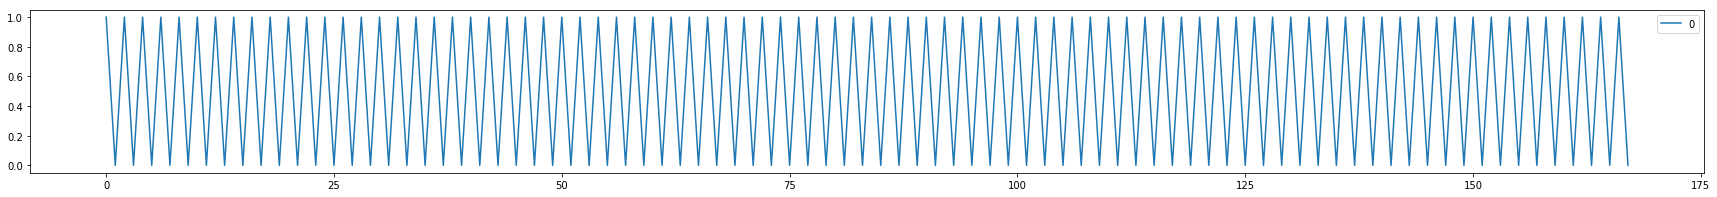

In [90]:
tID_list = dict()
tID_cur = dict()
tID_press = dict()
tID_release = dict()

for sec_input_line in sec_input_lines:
    if 'tID:' in sec_input_line:
        #print(sec_input_line)
        splited_sec_input = sec_input_line.split('tID:')[1]
        numbers = re.findall('\d+', splited_sec_input)
        tID = int(numbers[0])
        
        #display(tID)
        if tID not in tID_list:
            tID_list[tID] = list()
        if tID not in tID_cur:
            tID_cur[tID] = 0
        if tID not in tID_press:
            tID_press[tID] = 0
        if tID not in tID_release:
            tID_release[tID] = 0          

        if '[P]' in sec_input_line:
            tID_cur[tID] += 1
            tID_press[tID] += 1
        elif '[R]' in sec_input_line:
            tID_cur[tID] -= 1
            tID_release[tID] += 1

        if tID_cur[tID] not in tID_list[tID]:
            print(sec_input_line)

        tID_list[tID].append(tID_cur[tID])

print('\n\n')
for key in tID_list.keys():
    print('tID : {},     Count of press : {},  Count of release : {}'.format(key, tID_press[key], tID_release[key]))
    pd.DataFrame(tID_list[key]).plot(figsize=(30,3))
    plt.show()

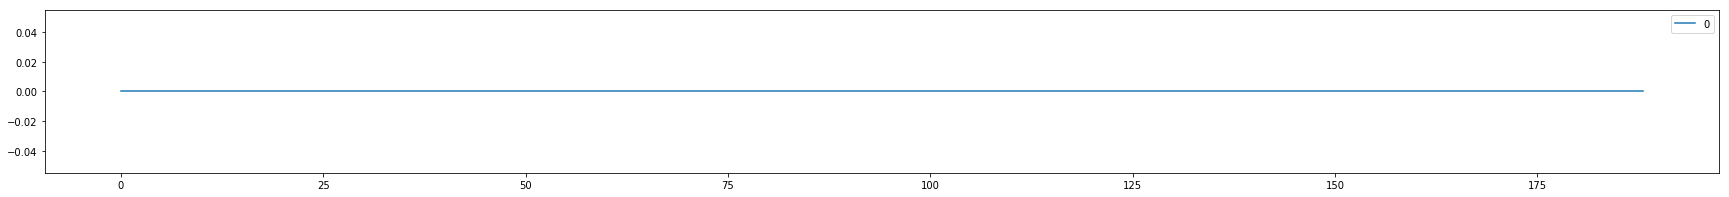

In [91]:
sec_input_noise = list()

for sec_input_line in sec_input_lines:
    #print(sec_input_line)
    if 'noise:(' in sec_input_line:
        #print(sec_input_line.split('noise:(')[1])
        number_of_noise = int(sec_input_line.split('noise:(')[1].split(',')[0])
        sec_input_noise.append(number_of_noise)
        if number_of_noise > 0:
            print(sec_input_line)
    elif 'noise:' in sec_input_line:
        #print(sec_input_line.split('noise:')[1])
        try:
            number_of_noise = int(sec_input_line.split('noise:')[1].split(',')[0])
        except:
            try:
                number_of_noise = int(sec_input_line.split('noise:')[1].split(' ')[0])
            except:
                try:
                    number_of_noise = int(sec_input_line.split('noise:')[1].split('/')[0])
                except:
                    print("parsing error : {}".format(sec_input_line))
        sec_input_noise.append(number_of_noise)
        if number_of_noise > 0:
            print(sec_input_line)
if len(sec_input_noise):
    df = pd.DataFrame(sec_input_noise)
    df.plot(figsize=(30,3))
else:
    print('---No data---')

In [92]:
lines = lp.log_sections['KERNEL LOG']
sec_input_lines = grep(lines,['NOISE MODE'], 1)

--- Nothing ---


* This logs are shown when processing input events normally after a problem happened.

In [93]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['Conflicting pointer actions'], 1)

--- Nothing ---


In [94]:
def printandinit():
    if checklog['kernel'] is False:
        print('>>>>> KERNEL LOG is missing!!! <<<<<')

    if checklog['reader'] is False:
        print('>>>>> InputReader LOG is missing!!! <<<<<')

    if checklog['dispatcher'] is False:
        print('>>>>> InputDispatcher LOG is missing!!! <<<<<')

    checklog['kernel'] = False
    checklog['reader'] = False
    checklog['dispatcher'] = False

lines = lp.log_sections['SYSTEM LOG']
Reader_Dispatchers = grep(lines,['InputDispatcher', 'InputReader'], 1, show=False)

lines = lp.log_sections['KERNEL LOG']
kernel_sec_inputs = grep(lines,['sec_input', '@Sync'], 1, show=False)

idx_reader_dispatcher = 0
idx_sec_input = 0

checklog = dict()
checklog['kernel'] = False
checklog['reader'] = False
checklog['dispatcher'] = False

sync_time = None
sync_kernel_log = None

while True:
    if idx_sec_input >= len(kernel_sec_inputs):
        break
    
    if idx_reader_dispatcher >= len(Reader_Dispatchers):
        break

    reader_dispatcher = Reader_Dispatchers[idx_reader_dispatcher]
    kernel_sec_input = kernel_sec_inputs[idx_sec_input]
    
    if '@Sync' in kernel_sec_input:
        androidtime = GetTime(kernel_sec_input)
        kerneltime = GetKernelTime(kernel_sec_input)

        if androidtime >= 0 and kerneltime >= 0:
            GAP_OF_TIME = androidtime - kerneltime
            sync_time = '[ SYNC {} = {} - {} ]'.format(GAP_OF_TIME, androidtime, kerneltime)
            sync_kernel_log = kernel_sec_input
        
        idx_sec_input += 1
        if idx_sec_input >= len(kernel_sec_inputs):
            break
        kernel_sec_input = kernel_sec_inputs[idx_sec_input]
            
    
    reader_dispatcher_time = GetTime(reader_dispatcher)
    if '[P]' in kernel_sec_input or '[R]' in kernel_sec_input or ' 114,' in kernel_sec_input or ' 115,' in kernel_sec_input or ' 116,' in kernel_sec_input:
        kernel_sec_input_time = GetKernelTime(kernel_sec_input) + GAP_OF_TIME
    elif 'Finger' in kernel_sec_input or 'gpio_keys_gpio_report_event' in kernel_sec_input:
        kernel_sec_input_time = GetKernelTime(kernel_sec_input) + GAP_OF_TIME
    else:
        idx_sec_input += 1
        continue
    
    if reader_dispatcher_time < kernel_sec_input_time:
        if 'InputReader' in reader_dispatcher:
            checklog['reader'] = True
            if checklog['kernel'] is False:
                if 'Btn_touch' in reader_dispatcher or 'Input event' in reader_dispatcher:
                    printandinit()
                    print("")
        if 'InputDispatcher' in reader_dispatcher:
            checklog['dispatcher'] = True
        print("{} - {}".format(reader_dispatcher_time, reader_dispatcher))
        idx_reader_dispatcher += 1
    else:
        printandinit()

        if sync_time is not None:
            print("")
            print(sync_time)
            print(sync_kernel_log)
            sync_time = None

        print("")
        if ' 114,' in kernel_sec_input:
            print("[[[ VOL UP KEY ]]]")
        elif ' 115,' in kernel_sec_input:
            print("[[[ VOL DN KEY ]]]")
        elif ' 116,' in kernel_sec_input:
            print("[[[ POWER KEY ]]]")
        print("{} - {}".format(kernel_sec_input_time, kernel_sec_input))
        idx_sec_input += 1
        checklog['kernel'] = True

10601549100 - 03-29 16:52:29.100  1000  1331  1331 D InputReader: Constructor for InputReader()
10601549177 - 03-29 16:52:29.177  5555   818   818 E audit   : type=1400 audit(1617004349.171:102): avc:  denied  { read } for  pid=1331 comm="InputReader" name="name" dev="sysfs" ino=79176 scontext=u:r:system_server:s0 tcontext=u:object_r:sysfs:s0 tclass=file permissive=0 SEPF_SM-G996N_11_0007 audit_filtered
10601549179 - 03-29 16:52:29.179  5555   818   818 E audit   : type=1400 audit(1617004349.175:103): avc:  denied  { read } for  pid=1331 comm="InputReader" name="name" dev="sysfs" ino=86990 scontext=u:r:system_server:s0 tcontext=u:object_r:sysfs:s0 tclass=file permissive=0 SEPF_SM-G996N_11_0007 audit_filtered
10601549180 - 03-29 16:52:29.180  5555   818   818 E audit   : type=1400 audit(1617004349.175:104): avc:  denied  { read } for  pid=1331 comm="InputReader" name="name" dev="sysfs" ino=88805 scontext=u:r:system_server:s0 tcontext=u:object_r:sysfs:s0 tclass=file permissive=0 SEPF_SM-

In [95]:
lines = lp.log_sections['SYSTEM LOG']
Reader_Dispatchers = grep(lines,['InputDispatcher', 'InputReader', 'HoneyBoardService onWindow'], 1, show=False)

focused_window = ""
missing_event = False
previous_line = ""

for line in Reader_Dispatchers:
    if 'HoneyBoardService onWindow' in line:
        print("===========================================")

    if 'InputReader' in line:
        if 'InputDispatcher' in previous_line:
            if missing_event is True and len(focused_window) > 0:
                print('>>>>> Input event to {} is missing!!! <<<<<'.format(focused_window))
            print("")
        missing_event = True

    if 'Delivering touch to' in line or 'Delivering key to' in line:
        splited_lines = line.split(' ')
        previous = ""
        for item in splited_lines:
            if 'to' == previous:
                if focused_window == item:
                    missing_event = False
                
            previous = item

    if 'Focus entered window' in line:
        splited_lines = line.split(' ')
        previous = ""
        for item in splited_lines:
            if 'window' == previous:
                focused_window = item
                
            previous = item
        missing_event = False

    if 'Focus left window' in line:
        missing_event = False

    previous_line = line
    print(line)

03-29 16:52:29.100  1000  1331  1331 D InputReader: Constructor for InputReader()
03-29 16:52:29.177  5555   818   818 E audit   : type=1400 audit(1617004349.171:102): avc:  denied  { read } for  pid=1331 comm="InputReader" name="name" dev="sysfs" ino=79176 scontext=u:r:system_server:s0 tcontext=u:object_r:sysfs:s0 tclass=file permissive=0 SEPF_SM-G996N_11_0007 audit_filtered
03-29 16:52:29.179  5555   818   818 E audit   : type=1400 audit(1617004349.175:103): avc:  denied  { read } for  pid=1331 comm="InputReader" name="name" dev="sysfs" ino=86990 scontext=u:r:system_server:s0 tcontext=u:object_r:sysfs:s0 tclass=file permissive=0 SEPF_SM-G996N_11_0007 audit_filtered
03-29 16:52:29.180  5555   818   818 E audit   : type=1400 audit(1617004349.175:104): avc:  denied  { read } for  pid=1331 comm="InputReader" name="name" dev="sysfs" ino=88805 scontext=u:r:system_server:s0 tcontext=u:object_r:sysfs:s0 tclass=file permissive=0 SEPF_SM-G996N_11_0007 audit_filtered
03-29 16:52:29.180  5555   

In [96]:
lines = lp.log_sections['SYSTEM LOG']
Reader_Dispatchers = grep(lines,['InputDispatcher', 'InputReader'], 1, show=True)

03-29 16:52:29.100  1000  1331  1331 D InputReader: Constructor for InputReader()
03-29 16:52:29.177  5555   818   818 E audit   : type=1400 audit(1617004349.171:102): avc:  denied  { read } for  pid=1331 comm="InputReader" name="name" dev="sysfs" ino=79176 scontext=u:r:system_server:s0 tcontext=u:object_r:sysfs:s0 tclass=file permissive=0 SEPF_SM-G996N_11_0007 audit_filtered
03-29 16:52:29.179  5555   818   818 E audit   : type=1400 audit(1617004349.175:103): avc:  denied  { read } for  pid=1331 comm="InputReader" name="name" dev="sysfs" ino=86990 scontext=u:r:system_server:s0 tcontext=u:object_r:sysfs:s0 tclass=file permissive=0 SEPF_SM-G996N_11_0007 audit_filtered
03-29 16:52:29.180  5555   818   818 E audit   : type=1400 audit(1617004349.175:104): avc:  denied  { read } for  pid=1331 comm="InputReader" name="name" dev="sysfs" ino=88805 scontext=u:r:system_server:s0 tcontext=u:object_r:sysfs:s0 tclass=file permissive=0 SEPF_SM-G996N_11_0007 audit_filtered
03-29 16:52:29.180  5555   

In [97]:
spent_lines = grep(Reader_Dispatchers,['spent'], 1, show=True)

--- Nothing ---


In [98]:
Reader_Dispatchers = grep(lines,['Touch event\'s action is'], 1, show=False)
for line in Reader_Dispatchers:
    if 'Btn_touch' in line:
        print('')
    print(line)

03-29 16:52:38.439  1000  1331  1539 I InputReader: Touch event's action is 0x0 (id=2, t=0) [pCnt=1, s=0.0 ] when=37.214219
03-29 16:52:38.581  1000  1331  1539 I InputReader: Touch event's action is 0x1 (id=2, t=0) [pCnt=1, s=] when=37.356687
03-29 16:52:40.976  1000  1331  1539 I InputReader: Touch event's action is 0x0 (id=2, t=0) [pCnt=1, s=0.1 ] when=39.750958
03-29 16:52:41.050  1000  1331  1539 I InputReader: Touch event's action is 0x1 (id=2, t=0) [pCnt=1, s=] when=39.825702
03-29 16:52:41.569  1000  1331  1539 I InputReader: Touch event's action is 0x0 (id=2, t=0) [pCnt=1, s=0.2 ] when=40.344278
03-29 16:52:41.635  1000  1331  1539 I InputReader: Touch event's action is 0x1 (id=2, t=0) [pCnt=1, s=] when=40.410594
03-29 16:52:41.961  1000  1331  1539 I InputReader: Touch event's action is 0x0 (id=2, t=0) [pCnt=1, s=0.3 ] when=40.736348
03-29 16:52:42.036  1000  1331  1539 I InputReader: Touch event's action is 0x1 (id=2, t=0) [pCnt=1, s=] when=40.811438
03-29 16:52:42.145  1000

In [99]:
lines = lp.log_sections['OLOG']
olog_locks = grep(lines, ['INPUTD'], 1)

--- Nothing ---


* Touch HW error<br>
ex) An error occured at Rx36<br>
[    5.247112] sec_ts 2-0048 : Rx34 |  307 319 320 322 327 327 328 333 334 332 329 327 326 323 321 319 324<br>
[    5.247129] sec_ts 2-0048 : Rx35 |  313 325 327 329 333 333 335 340 342 340 337 335 333 331 329 325 330<br>
[    5.247146] sec_ts 2-0048 : Rx36 |   -1   0   0  -1   0   0   0   0   0   0   0   0   0   0   0   0   0<br>
[    5.247163] sec_ts 2-0048 : Rx37 |  207 254 256 258 261 261 262 268 226 268 264 262 261 259 257 255 228<br>

In [100]:
lines = lp.log_sections['KERNEL LOG']
sec_input_lines = grep(lines,['sec_ts'], 1, show=False)
lines = lp.log_sections['TSP RAW DATA']
sec_input_lines += grep(lines,['sec_ts'], 1, show=False)

x = list()
x_ = list()
for sec_input_line in sec_input_lines:
    if re.search("Rx00", sec_input_line):
        if len(x_) > 0:
            x.append(x_)
            x_ = list()
            print("")
    if re.search("Rx[0-9][0-9]", sec_input_line):
        print(sec_input_line)
        splited = sec_input_line.split('|')
        if len(splited) > 0:
            splited_items = splited[1].split(' ')
            for splited_item in splited_items:
                if len(splited_item) > 0:
                    x_.append(int(splited_item))
x.append(x_)

--- Nothing ---


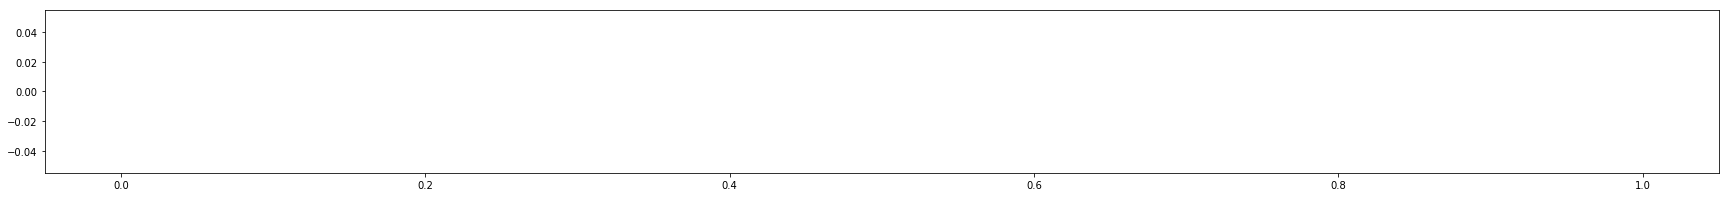

mean : nan,  standard deviation : nan


/home/ubuntu/.local/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice.
  import sys
/home/ubuntu/.local/lib/python2.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/.local/lib/python2.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ubuntu/.local/lib/python2.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/ubuntu/.local/lib/python2.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [101]:
for x_ in x:
    plt.figure(figsize=(30, 3))
    plt.hist(x_, bins = 40)
    plt.show()

    arr = np.array(x_)
    print("mean : {},  standard deviation : {}".format(arr.mean(), arr.std()))

In [102]:
x = list()
x_ = list()
for sec_input_line in sec_input_lines:
    if re.search("Rx00", sec_input_line):
        if len(x) > 0:
            df = pd.DataFrame(x, columns=['TX' + str(i) for i in range(0,len(x[0]))], index = ['RX' + str(i) for i in range(0,len(x))])
            x = list()
            display(df.style.background_gradient(cmap='coolwarm'))

    if re.search("Rx[0-9][0-9]", sec_input_line):
        #print(sec_input_line)
        splited = sec_input_line.split('|')
        if len(splited) > 0:
            splited_items = splited[1].split(' ')
            for splited_item in splited_items:
                if len(splited_item) > 0:
                    x_.append(int(splited_item))
            x.append(x_)
            x_ = list()

# <span style="color:blue">[BOTTLENECKS]</span> 

* If 'dalvik.vm.lockprof.threshold' property is not exist, lock monitor contention is off.

In [103]:
lines = lp.log_sections['SYSTEM PROPERTIES']
tmp = grep(lines,['dalvik.vm.lockprof.threshold'], 1)

[dalvik.vm.lockprof.threshold]: [500]


In [104]:
lines = lp.log_sections['SYSTEM LOG']
Long_monitor_lines = grep(lines,['Long monitor contention with owner'], 1)

03-29 16:52:44.400  1000  1331  1573 W system_server: Long monitor contention with owner android.fg (1392) at void com.android.server.appwidget.AppWidgetServiceImpl.reloadWidgetsMaskedStateForGroup(int)(AppWidgetServiceImpl.java:749) waiters=0 in boolean com.android.server.appwidget.AppWidgetServiceImpl.isBoundWidgetPackage(java.lang.String, int) for 324ms
03-29 16:52:45.528 10287  4239  4533 W s.youtube.musi: Long monitor contention with owner yt-background12-8 (4539) at zbs dru.aw()(PG:8) waiters=0 in zbs dru.aw() for 440ms
03-29 16:52:46.013 10062  1796  4874 W ndroid.systemu: Long monitor contention with owner pool-18-thread-2 (4876) at android.content.IContentProvider android.app.ActivityThread.acquireProvider(android.content.Context, java.lang.String, int, boolean)(ActivityThread.java:7589) waiters=0 in android.content.IContentProvider android.app.ActivityThread.acquireProvider(android.content.Context, java.lang.String, int, boolean) for 486ms
03-29 16:52:46.027 10062  1796  4974

In [105]:
lines = lp.log_sections['SYSTEM LOG']
Long_monitor_lines = grep(lines,['Slow delivery took'], 1)

03-29 16:52:33.248  1000  1331  1331 W Looper  : Slow delivery took 4715ms main h=com.android.server.VaultKeeperService$1 c=null m=1
03-29 16:52:37.329  1000  1331  1392 W Looper  : Slow delivery took 382ms android.fg h=com.android.server.adb.AdbDebuggingManager$AdbDebuggingHandler c=null m=8
03-29 16:52:37.680  1000  1331  1611 W Looper  : Slow delivery took 250ms PackageManagerHandlerThread h=android.os.Handler c=<recycled PooledLambda@fbf67b2> m=0
03-29 16:52:44.119  1000  1331  1331 W Looper  : Slow delivery took 233ms main h=com.android.server.job.JobSchedulerService$JobHandler c=null m=4
03-29 16:52:44.408  1000  1331  1392 W Looper  : Slow delivery took 390ms android.fg h=android.os.Handler c=com.android.server.am.-$$Lambda$UserController$iNxcwiechN4VieHO-D0SwsPl6xc@f4b040f m=0
03-29 16:52:46.899  1000  1331  1393 W Looper  : Slow delivery took 220ms android.ui h=android.hardware.display.DisplayManagerGlobal$DisplayListenerDelegate c=null m=2
03-29 16:52:50.556  1000  1331  1331

In [106]:
tmp = grep(Long_monitor_lines,['[0-9].[0-9][0-9][0-9]s', '[5-9][0-9][0-9]ms', '[0-9][0-9][0-9][0-9]ms'], 1)

03-29 16:52:33.248  1000  1331  1331 W Looper  : Slow delivery took 4715ms main h=com.android.server.VaultKeeperService$1 c=null m=1
03-29 16:53:14.516  1000  1331  1331 W Looper  : Slow delivery took 528ms main h=android.app.ActivityThread$H c=android.app.-$$Lambda$LoadedApk$ReceiverDispatcher$Args$_BumDX2UKsnxLVrE6UJsJZkotuA@132b443 m=0
03-29 16:57:55.575  1000  1331  1331 W Looper  : Slow delivery took 3541ms main h=android.app.ActivityThread$H c=android.app.-$$Lambda$LoadedApk$ReceiverDispatcher$Args$_BumDX2UKsnxLVrE6UJsJZkotuA@b7392fa m=0


In [107]:
lines = lp.log_sections['EVENT LOG']
tmp = grep(lines,['dvm_lock_sample'], 1)

03-29 16:52:37.313  1000  1331  2594 I dvm_lock_sample: [system_server,1,Binder:1331_D,304,ActivityManagerService.java,6649,void com.android.server.am.ActivityManagerService.attachApplication(android.app.IApplicationThread, long),,0,null,60]
03-29 16:52:37.315  1000  1331  1446 I dvm_lock_sample: [system_server,0,PackageManager,266,ActivityManagerService.java,22811,int com.android.server.am.ActivityManagerService$LocalService.broadcastIntent(android.content.Intent, android.content.IIntentReceiver, java.lang.String[], boolean, int, int[]),,0,null,53]
03-29 16:52:37.317  1000  1331  1331 I dvm_lock_sample: [system_server,1,main,265,ActivityManagerService.java,18007,void com.android.server.am.ActivityManagerService.serviceDoneExecuting(android.os.IBinder, int, int, int),,0,null,53]
03-29 16:52:37.327  1000  1331  1392 I dvm_lock_sample: [system_server,0,android.fg,324,ActivityManagerService.java,19730,int com.android.server.am.ActivityManagerService.broadcastIntentWithFeature(android.app.

* Critical issues in OLOG.

In [108]:
lines = lp.log_sections['OLOG']
olog_locks = grep(lines, ['MAINLOOPER', 'LOCKCONTENTION', 'LOADAPK', 'INPUTD'], 1)

[03-29 16:52:37.317 1  1331     0 ( 73)][LOG][MAINLOOPER]  Slowdispatch took 266ms main h=android.app.ActivityThread$H c=null m=114
[03-29 16:52:37.600 1  1331     0 (128)][LOG][MAINLOOPER]  Slowdispatch took 273ms main h=android.app.ActivityThread$H c=android.app.LoadedApk$ServiceDispatcher$RunConnection@d502069 m=0
[03-29 16:52:37.822 1  1331     0 (177)][LOG][LOADAPK]  system_server main thread handled for android.intent.action.LOCKED_BOOT_COMPLETED took 111 ms, Receiver = com.android.server.enterprise.application.ApplicationPolicy$11@7138c66
[03-29 16:52:37.822 1  1331     0 (158)][LOG][MAINLOOPER]  Slowdispatch took 111ms main h=android.app.ActivityThread$H c=android.app.-$$Lambda$LoadedApk$ReceiverDispatcher$Args$_BumDX2UKsnxLVrE6UJsJZkotuA@b3e8dd2 m=0
[03-29 16:52:44.119 1  1331     0 (127)][LOG][MAINLOOPER]  Slowdispatch took 232ms main h=com.android.server.cocktailbar.CocktailBarManagerServiceContainer$CocktailBarHandler c=null m=4
[03-29 16:52:44.119 1  1331     0 ( 96)][LOG]

In [109]:
olog_locks = grep(olog_locks, ['[0-9][0-9][0-9][0-9]ms',], 1)

[03-29 16:52:52.132 1  1331     0 (129)][LOG][MAINLOOPER]  Slowdispatch took 1289ms main h=android.app.ActivityThread$H c=android.app.LoadedApk$ServiceDispatcher$RunConnection@841dece m=0
[03-29 16:52:52.132 1  1331     0 (205)][LOG][MAINLOOPER]  Slowdelivery took 1272ms main h=com.android.server.notification.NotificationManagerService$WorkerHandler c=com.android.server.notification.NotificationManagerService$CancelNotificationRunnable@742d1ef m=0


In [110]:
lines = lp.log_sections['OLOG']
olog_locks = grep(lines, ['LOCKCONTENTION',], 1)

[03-29 16:52:51.465 2  1331     0 ( 26)][EVT][LOCKCONTENTION] Binder:1331_1A/508//0/null
[03-29 16:52:51.467 2  1331     0 ( 25)][EVT][LOCKCONTENTION] Binder:1331_F/510//0/null
[03-29 16:52:51.468 2  1331     0 ( 22)][EVT][LOCKCONTENTION] android.ui/510//0/null
[03-29 16:52:51.468 2  1331     0 ( 26)][EVT][LOCKCONTENTION] Binder:1331_1E/510//0/null
[03-29 16:52:51.479 2  1331     0 ( 26)][EVT][LOCKCONTENTION] Binder:1331_17/522//0/null
[03-29 16:52:51.481 2  1331     0 ( 26)][EVT][LOCKCONTENTION] Binder:1331_1B/507//0/null
[03-29 16:52:51.483 2  1331     0 ( 26)][EVT][LOCKCONTENTION] Binder:1331_18/513//0/null
[03-29 16:52:52.132 2  1331     0 ( 18)][EVT][LOCKCONTENTION] [DELAY_INFO] LOCKC
[03-29 16:52:52.132 2  1331     0 (122)][EVT][LOCKCONTENTION] main/1288/TimeController.java/335/void com.android.server.job.controllers.TimeController.checkExpiredDelaysAndResetAlarm()
[03-29 16:52:52.133 2  1331     0 ( 18)][EVT][LOCKCONTENTION] [DELAY_INFO] LOCKC
[03-29 16:52:52.133 2  1331     0 (

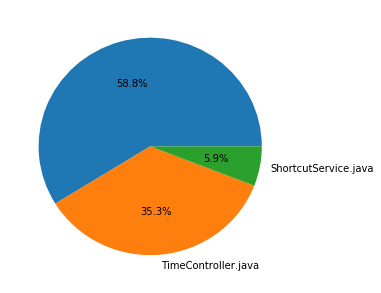

In [111]:
locks_state = dict()
for line in olog_locks:
    if 'LOCKCONTENTION' in line:
        splited_line = line.split('/')
        if len(splited_line) > 2:
            status = splited_line[2]
            locks_state[status] = locks_state.get(status, 0) + 1

#df.plot.pie(y='0', figsize=(5, 5), autopct='%1.1f%%', startangle=100)
plt.figure(figsize=(5, 5))
plt.pie(locks_state.values(), labels = locks_state.keys(), autopct='%1.1f%%') 
plt.show() 

In [112]:
lines = lp.log_sections['OLOG']
olog_locks = grep(lines, ['MUTEX'], 1)

--- Nothing ---


In [113]:
lines = lp.log_sections['OLOG']
olog_locks = grep(lines, ['PSI'], 1)

--- Nothing ---


In [114]:
lines = lp.log_sections['OLOG']
tmp = grep(lines,['APPLAUNCH', 'LCDV'], 1)

[03-29 16:52:33.340 2  1331     0 ( 38)][EVT][APPLAUNCH] com.android.settings/.FallbackHome [S]
[03-29 16:52:33.340 2  1331     0 ( 24)][EVT][APPLAUNCH] com.android.settings [C]
[03-29 16:52:34.653 2  1331     0 ( 24)][EVT][APPLAUNCH] com.android.settings [C]
[03-29 16:52:37.353 2  1331     0 ( 24)][EVT][APPLAUNCH] com.android.settings [C]
[03-29 16:52:37.452 2  1331     0 ( 98)][EVT][APPLAUNCH] com.samsung.android.app.telephonyui/.carrierui.networkui.app.AllowDataConnectionDialogActivity [S]
[03-29 16:52:37.820 2  1331     0 (104)][EVT][APPLAUNCH] com.samsung.android.app.telephonyui/.carrierui.networkui.app.AllowDataConnectionDialogActivity [368] [E]
[03-29 16:52:42.934 2  1331     0 ( 24)][EVT][APPLAUNCH] com.android.settings [C]
[03-29 16:52:42.967 2  1331     0 ( 45)][EVT][APPLAUNCH] com.android.settings/.FallbackHome [9632] [E]
[03-29 16:52:42.973 1  1331     0 (171)][LOG][APPLAUNCH] [com.samsung.android.app.telephonyui],com.samsung.android.app.telephonyui.carrierui.networkui.app.

In [115]:
lines = lp.log_sections['OLOG']
olog_locks = grep(lines, ['AVG=[5-9][0-9]'], -80, show=False)

for olog_lock in olog_locks:
    if '/0/null' not in olog_lock and '[DELAY_INFO] LOCKC' not in olog_lock:
        print(olog_lock)

--- Nothing ---


In [116]:
lines = lp.log_sections['SYSTEM LOG']
Long_monitor_lines = grep(lines,['INTENT_ACTION_BOTTLENECK_HINT'], 1)

--- Nothing ---


In [117]:
lines = lp.log_sections['OLOG']
olog_locks = grep(lines, ['INPUTD'], 1)

--- Nothing ---


In [118]:
lines = lp.log_sections['SYSTEM LOG']
olog_locks = grep(lines, ['dex2oat took'], 1)

03-29 16:52:25.749  1000  1349  1349 I dex2oat32: dex2oat took 106.333ms (157.333ms cpu) (threads: 8) arena alloc=0B (0B) java alloc=288KB (295544B) native alloc=2133KB (2184672B) free=2469KB (2529040B)
03-29 16:52:31.443 50228  1704  1704 I dex2oat32: dex2oat took 68.129ms (90.241ms cpu) (threads: 6) arena alloc=3464B (3464B) java alloc=16KB (16800B) native alloc=1220KB (1250096B) free=1896KB (1942384B)
03-29 16:52:31.548  1073  1712  1712 I dex2oat32: dex2oat took 80.499ms (239.916ms cpu) (threads: 6) arena alloc=6344B (6344B) java alloc=282KB (289704B) native alloc=1510KB (1546496B) free=3070KB (3144608B)
03-29 16:52:31.844 50079  1721  1721 I dex2oat32: dex2oat took 271.205ms (773.978ms cpu) (threads: 6) arena alloc=1038KB (1063128B) java alloc=66KB (67728B) native alloc=5982KB (6125712B) free=3834KB (3926160B)
03-29 16:53:30.004  1073 13749 13749 I dex2oat32: dex2oat took 104.616ms (140.427ms cpu) (threads: 6) arena alloc=0B (0B) java alloc=135KB (138928B) native alloc=1719KB (176

# <span style="color:blue">[GAME]</span> 

### History of game packages

In [119]:
lines = ssrm.file_lines
game_lines = grep(lines,['DSS :', 'PKG'], 1, show=False)
game_lines = grep(game_lines,['DSS :'], 2)

--- Nothing ---


In [120]:
lines = ssrm.file_lines
game_lines = grep(lines,['DSS :', 'SPA', 'GAMESDK', 'GameThermalCpuControl'], 1)

--- Nothing ---


In [121]:
searchers = dict()
searchers['FPS'] = 0
searchers['CF'] = 1
searchers['GF'] = 1
searchers['Lv'] = 0

fps_cf = DictFromPickedUp(game_lines, searchers)

#display(fps_cf['Lv-'])

if len(game_lines) > 0:
    df = pd.DataFrame(fps_cf)
    df = df.replace(1, CPU_MAX_FREQ/1000)

    if 'FPS' in df.columns and len(df['FPS']) > 0:
        df['FPS'].plot(figsize=(30,4), legend=True)
        plt.ylim(0, 120)
    if 'CF' in df.columns and len(df['CF']) > 0:
        df['CF'].plot(secondary_y=True, color='red', figsize=(30,4), legend=True)
    if 'FPS' in df.columns and len(df['FPS']) > 0 and 'CF' in df.columns and len(df['CF']) > 0:
        df.plot.scatter('FPS', 'CF', figsize=(30,10))
        plt.xlim(0, 120)

In [122]:
if len(game_lines) > 0:
    if 'FPS' in df.columns and len(df['FPS']) > 0:
        df['FPS'].plot(figsize=(30,4), legend=True)
        plt.ylim(0, 120)
    if 'GF' in df.columns and len(df['GF']) > 0:
        df['GF'].plot(secondary_y=True, figsize=(30,4), legend=True)
    if 'FPS' in df.columns and len(df['FPS']) > 0 and 'GF' in df.columns and len(df['GF']) > 0:
        df.plot.scatter('FPS', 'GF', figsize=(30,10))
        plt.xlim(0, 120)

In [123]:
if len(game_lines) > 0:
    df = pd.DataFrame(fps_cf)

    if 'FPS' in df.columns and len(df['FPS']) > 0:
        df['FPS'].plot(figsize=(30,4), legend=True)
        plt.ylim(0, 120)
    if 'Lv' in df.columns and len(df['Lv']) > 0:
        df['Lv'].plot(secondary_y=True, color='purple', figsize=(30,4), legend=True)

# <span style="color:blue">[TENDS]</span> 

* Focus on the lines on TOP logs when LCD on, because TOP logs have to be false alarm when LCD is off.

In [124]:
lines = ssrm.file_lines
top_lines = grep(lines,['TOP', 'LCD', 'PKG', '===== '], 1, show=False)

top_lines_with_LCD_on = MarkupLCDON(top_lines)

TOP DUMP Based on SIOP Level============================================================================================================================================================================================================
2021-03-28 12:30:28 [PKG] com.kakao.talk
2021-03-28 12:30:30 [SET] [ND0XXXOMAXXXXXXWOX / Wifi:"KT_GiGA_Mesh_F658",2457MHz] [LCD] OFF 7286
2021-03-28 12:34:22 [TOP] [surfaceflinger=2.91%] [system_server=1.53%] [samsung.hardware.media.c2@1.0-service=1.06%] [android.hardware.graphics.composer@2.4-service=0.73%] [com.sec.android.app.launcher=0.59%]
2021-03-28 12:36:29 [SET] [ND0XOXOMAXXXXXXWOX / Wifi:"KT_GiGA_Mesh_F658",2457MHz] [LCD] ON 7281  [sleep_count = 22, sleep_time_sec = 320]
2021-03-28 12:36:32 [SET] [ND0XXXOMAXXXXXXWOX / Wifi:"KT_GiGA_Mesh_F658",2457MHz] [LCD] OFF 7280
2021-03-28 12:40:03 [SET] [ND0XOXOMAXXXXXXWOX / Wifi:"KT_GiGA_Mesh_F658",2457MHz] [LCD] ON 7276  [sleep_count = 8, sleep_time_sec = 186]
 LCDON >>> 2021-03-28 12:40:11 [PKG] com.sec.and

In [134]:
lines = ssrm.file_lines
net_lines = grep(lines,['COM'], 1)

[COM] [(SIOP Level)(AP_temp,PST_temp,BAT_temp,USB_temp,CHG_temp,PA_temp,CP_temp,MMW_temp,WIFI_temp,CF_temp,BLK_temp,SUBBAT_temp,LRP_temp,LRP2_temp<LRP2_type>,(BAT_level,Inow_avg,Isys_avg)(RSSI[common,Gsm/Cdma/Lte],Radio_data,Radio_RxTput,Radio_TxTput,Wifi_data,Wifi_signal_Level,Wifi_RxTput,Wif_TxTput)(Brightness,FPS,HRR),(Vidoe_Audio,AudioDevice:Volume)]
2021-02-03 17:06:14 [COM] [(-2->-2)(37,36,32,32,38,34,33,--,34,--,--,--,33,--:    -)( 75, 1753, 131)([ -92_1, 4G13],R:   0K,Rx:  0.0Mbps,Tx:  0.0Mbps,W:  28M,Lv-4,Rx:  0.1Mbps,Tx:  0.1Mbps)(BL: 92,FPS: 1.3,NA)(__,SPK: 0)][Core:0-7][CF! 520/2730,GF| 156/ 754,CG: -1,WT: -1,AD: 5,LB: -1,SB:-1,HT: -1,CL: 4,VL:-1,BG: -1,CO:-1,DR:-1,WP: -1] [LRPs => LRF:336 LRB:336] ScreenOff LowTput CPU : -1
2021-02-03 17:07:25 [COM] [(-2->-2)(35,36,32,31,37,33,32,--,33,--,--,--,32,--:    -)( 76, 1638, 250)([ -80_1, 4G13],R:   0K,Rx:  0.0Mbps,Tx:  0.0Mbps,W:   2M,Lv-4,Rx:  0.3Mbps,Tx:  0.2Mbps)(BL: 92,FPS: 1.5,NA)(__,SPK: 0)][Core:0-7][CF! 520/2730,GF| 156/

Text(0,0.5,'Mbps')

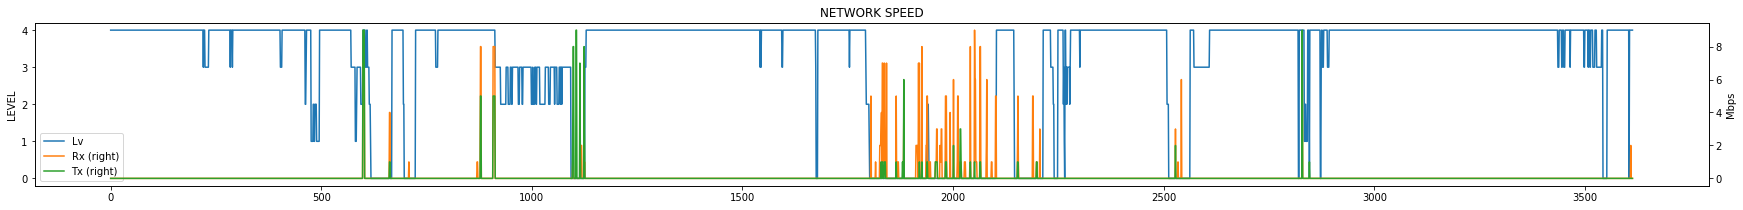

In [135]:
searchers = dict()
searchers['Lv'] = 0
searchers['Rx'] = 1
searchers['Tx'] = 1
network = DictFromPickedUp(net_lines, searchers)

#display(network['Lv'])
df = pd.DataFrame(network)
ax = df['Lv'].plot(figsize=(30,5), legend=True)
ax.set_title('NETWORK SPEED')
ax.set_ylabel('LEVEL')

ax = df['Rx'].plot(secondary_y=True, figsize=(30,3), legend=True)
ax = df['Tx'].plot(secondary_y=True, figsize=(30,3), legend=True)
ax.set_ylabel('Mbps')

In [136]:
lines = lp.log_sections['SERVICE wifi']
tmp = grep(lines,['setWifiEnabled'], 1)

--- Nothing ---


* Netwrok error with NETWORK_VALIDATION_FAILED(This is MAJOR log)<br>
ex) ConnectivityMetricsEvent(2020-08-20 13:28:44.085, netId=604, CELLULAR): NetworkEvent(NETWORK_VALIDATION_FAILED, 0ms)

In [137]:
lines = lp.log_sections['DUMP OF SERVICE connmetrics']
tmp = grep(lines,['FAILED'], 1)

--- Nothing ---


* Wifi error logs(This is minor log)<br>
08-26 17:29:14.405  wifi  2651  2651 E WifiHAL : Failed to execute bssid blacklist request, result = -22<br>
08-26 17:29:14.405  wifi  2651  2651 E WifiHAL : wifi_configure_roaming: Failed to configure blacklist bssids<br>
08-26 17:29:14.405  1000  4456  4638 E WifiVendorHal: configureRoaming(l.2084) failed {.code = ERROR_UNKNOWN, .description = unknown}<br>

In [138]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['Failed to execute bssid blacklist request', 'Failed to configure blacklist bssids', 'failed {.code = ERROR_UNKNOWN'], 1)

--- Nothing ---


* Wifi error logs

If there are many APs likes below, those could effect to the current network.

Latest scan results:<br>
    BSSID.............Frequency.......RSSI.......BSS Load Element......Age(sec)...SSID..................................Flags<br>
  10:6f:3f:09:27:63.......2412........-55................null...........23.081....106F3F092763......................[WPA2-PSK-CCMP+TKIP][RSN-PSK-CCMP+TKIP][WPA-PSK-CCMP+TKIP][ESS][WPS]<br>
  bc:96:80:a6:44:e1.......2427........-59................null...........23.081....U+Net44E3.........................[WPA2-PSK-CCMP][RSN-PSK-CCMP][ESS]<br>
  f8:b4:6a:ff:d3:73.......2432........-60................null...........23.081....DIRECT-72-SA SL-J2160W Series.....[WPA2-PSK-CCMP][RSN-PSK-CCMP][ESS][WPS]<br>
  bc:96:80:a6:44:e4.......2427........-60................null...........23.081....U+zone............................[WPA2-EAP-CCMP][RSN-EAP-CCMP][ESS]<br>
  70:5d:cc:58:79:34.......2432........-65................null...........23.081....iptime_seonhui....................[WPA2-PSK-CCMP][RSN-PSK-CCMP][ESS][WPS]<br>
  bc:96:80:a6:44:e0.......2427........-67................null...........23.081......................................[WPA-PSK-TKIP][ESS]<br>
  88:36:6c:8d:14:cc.......2417........-77..........000000127A...........23.081....iptime............................[WPA2-PSK-CCMP][RSN-PSK-CCMP][ESS][WPS]<br>
  b4:a9:4f:4f:d3:5a.......2427........-86..........00000D127A...........23.081....KT_GiGA_2G_Wave2_D356.............[WPA-PSK-CCMP+TKIP][WPA2-PSK-CCMP+TKIP][RSN-PSK-CCMP+TKIP][ESS][WPS]<br>
  18:c5:01:c5:d1:de.......2427........-88................null...........23.081....U+NetD1DC.........................[WPA2-PSK-CCMP][RSN-PSK-CCMP][ESS]<br>
  00:07:89:6b:56:32.......2432........-89................null...........23.081....olleh_WiFi_562F...................[WPA2-PSK-CCMP+TKIP][RSN-PSK-CCMP+TKIP][WPA-PSK-CCMP+TKIP][ESS][WPS]<br>
  86:25:19:2f:a6:11.......2412........-91................null...........23.081....DIRECT-ujC48x Series..............[WPA2-PSK-CCMP][RSN-PSK-CCMP][ESS][WPS]<br>
  88:3c:1c:ed:90:22.......2412........-93................null...........23.081....U+Net9023.........................[WPA2-PSK-CCMP][RSN-PSK-CCMP][ESS]<br>
  f4:d9:fb:20:64:c9.......2412........-93................null...........23.081....KT_WLAN_19E0......................[WPA2-PSK-CCMP+TKIP][RSN-PSK-CCMP+TKIP][WPA-PSK-CCMP+TKIP][ESS]<br>
  54:d1:63:2e:8e:f3.......2412........-96................null...........23.081....t-broad8EED.......................[WPA-PSK-TKIP+CCMP][WPA2-PSK-TKIP+CCMP][RSN-PSK-TKIP+CCMP][ESS][WPS]<br>

In [139]:
lines = lp.log_sections['DUMP OF SERVICE wifiscanner']
tmp = grep(lines,['Latest scan results'], 30)

Latest scan results:
BSSID              Frequency      RSSI           Age(sec)     SSID                                 Flags
00:07:89:4f:13:ed       2442        -30             82.223    KT_GiGA_2G_모르는개산책                 [WPA2-PSK-CCMP+TKIP][RSN-PSK-CCMP+TKIP][WPA-PSK-CCMP+TKIP][ESS][WPS]
00:07:89:4f:13:ee       5765        -66             82.223    KT_GiGA_5G_오즈의맙소사                 [WPA2-PSK-CCMP+TKIP][RSN-PSK-CCMP+TKIP][WPA-PSK-CCMP+TKIP][ESS][WPS]
00:27:1c:bd:19:87       2412        -70             82.223    KT_WLAN_BD98                      [WPA-PSK-TKIP+CCMP][WPA2-PSK-TKIP+CCMP][RSN-PSK-TKIP+CCMP][ESS][WPS]
02:27:1c:bd:19:87       2412        -73             82.223                                      [WPA-PSK-TKIP+CCMP][WPA2-PSK-TKIP+CCMP][RSN-PSK-TKIP+CCMP][ESS]
86:a9:3e:b9:82:2d       5765        -77             82.223    DIRECT-2D-HP OfficeJet 5200       [WPA2-PSK-CCMP][RSN-PSK-CCMP][ESS][WPS]
08:5d:dd:92:67:b7       2437        -85             82.223    olleh_WiFi_67B3      

* Some delay related for telecom could be founded, if the count of registration is large number.

09-18 13:58:56.701  1000  4398  4398 W Looper  : Slow system_server main looper dispatch took 3908ms  h=android.telecom.Connection$VideoProvider$VideoProviderHandler c=null m=9

In [140]:
lines = lp.log_sections['DUMP OF SERVICE telephony.registry']
tmp = grep(lines,['registrations'], 1)

registrations: count=85


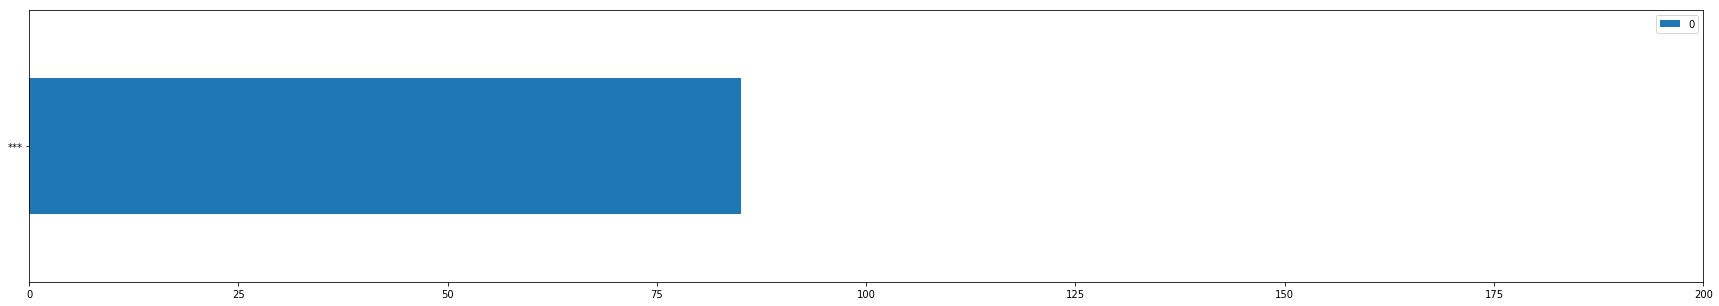

In [141]:
lines = lp.log_sections['DUMP OF SERVICE telephony.registry']
callingPackages = grep(lines,['callingPackage'], 1, show=False)

callingPackages_dict = dict()
for callingPackage in callingPackages:
    current_data = callingPackage.split(' ')[0][16:]
    callingPackages_dict[current_data] = callingPackages_dict.get(current_data, 0) + 1

df = pd.DataFrame.from_dict(callingPackages_dict, orient='index')
df.plot(kind='barh', figsize=(30,5), xlim=(0,200))
plt.show()

* This is reaction time of medem.

19:50:00.000: {netId=618, CELLULAR, dns avg=2048ms max=14381ms err=4.5% tot=44, connect avg=0ms max=1ms err=0.0% tot=44, tcp avg_loss=0.0% total_sent=14092 total_lost=0, tcp rtt=595ms, tcp sent-ack_diff=-4110ms}<br>
19:55:00.000: {netId=618, CELLULAR, dns avg=3259ms max=9457ms err=7.1% tot=14, connect avg=0ms max=3ms err=0.0% tot=224, tcp avg_loss=0.3% total_sent=13517 total_lost=45, tcp rtt=2860ms, tcp sent-ack_diff=-3084ms}

In [142]:
lines = lp.log_sections['DUMP OF SERVICE connmetrics']
network_logs = grep(lines,['dns avg'], 1, show=False)
network_logs = grep(network_logs, ['max=[0-9][0-9][0-9][0-9]ms', 'err=[0-9][0-9].[0-9]%'], 1)

10:37:00.000: {netId=0, dns avg=0ms max=0ms err=0.0% tot=1, connect avg=0ms max=0ms err=0.0% tot=0, tcp avg_loss=0.0% total_sent=0 total_lost=0, tcp rtt=0ms, tcp sent-ack_diff=0ms}, {netId=501, CELLULAR, dns avg=12ms max=25ms err=0.0% tot=2, connect avg=0ms max=0ms err=0.0% tot=2, tcp avg_loss=0.0% total_sent=0 total_lost=0, tcp rtt=0ms, tcp sent-ack_diff=0ms}, {netId=601, CELLULAR, dns avg=45ms max=170ms err=0.0% tot=9, connect avg=0ms max=0ms err=0.0% tot=5, tcp avg_loss=0.0% total_sent=0 total_lost=0, tcp rtt=0ms, tcp sent-ack_diff=0ms}, {netId=602, WIFI, dns avg=15ms max=40ms err=0.0% tot=6, connect avg=0ms max=0ms err=16.7% tot=6, tcp avg_loss=0.0% total_sent=0 total_lost=0, tcp rtt=0ms, tcp sent-ack_diff=0ms}
10:39:00.000: {netId=602, WIFI, dns avg=14ms max=179ms err=16.9% tot=83, connect avg=0ms max=1ms err=0.0% tot=70, tcp avg_loss=0.5% total_sent=402 total_lost=2, tcp rtt=104ms, tcp sent-ack_diff=-142ms}, {netId=603, CELLULAR, dns avg=0ms max=0ms err=0.0% tot=0, connect avg=0m

# <span style="color:blue">[WINDOWMANAGER]</span>

* This log should be checked by framework team, but this is app problem in most of cases.

In [143]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['APP TRANSITION TIMEOUT'], 1)

--- Nothing ---


* stopFreezingDisplayInnerLocked can be happenning with changing orientation.

   <t>last=0 : H<br>
   <t>last=1 : V

In [144]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['stopFreezingDisplayInnerLocked', 'rotationForOrientation'], 1)

02-05 10:36:42.035  1000   979  1014 V WindowManager: rotationForOrientation(orient=SCREEN_ORIENTATION_NOSENSOR (5), last=ROTATION_0 (0)); user=ROTATION_0 (0) USER_ROTATION_LOCKED
02-05 10:36:42.039  1000   979  1014 V WindowManager: rotationForOrientation(orient=SCREEN_ORIENTATION_NOSENSOR (5), last=ROTATION_0 (0)); user=ROTATION_0 (0) USER_ROTATION_LOCKED
02-05 10:38:08.226  1000   979  1012 V WindowManager: rotationForOrientation(orient=SCREEN_ORIENTATION_NOSENSOR (5), last=ROTATION_0 (0)); user=ROTATION_0 (0) USER_ROTATION_LOCKED
02-05 10:38:08.828  1000   979  1012 V WindowManager: rotationForOrientation(orient=SCREEN_ORIENTATION_NOSENSOR (5), last=ROTATION_0 (0)); user=ROTATION_0 (0) USER_ROTATION_LOCKED
02-05 10:38:10.980  1000   979  1508 V WindowManager: rotationForOrientation(orient=SCREEN_ORIENTATION_NOSENSOR (5), last=ROTATION_0 (0)); user=ROTATION_0 (0) USER_ROTATION_LOCKED
02-05 10:38:11.162  1000   979  1012 V WindowManager: rotationForOrientation(orient=SCREEN_ORIENTATI

* SurfaceComposerClient could have out of memory problem during creating surface.

In [145]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['Out of memory'], 1)

--- Nothing ---


In [146]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['SurfaceFlinger'], 1)

02-05 10:36:18.367  1000   549   549 I HidlServiceManagement: Registered android.hardware.configstore@1.1::ISurfaceFlingerConfigs/default (start delay of 37ms)
02-05 10:36:18.685  1000   628   628 I SurfaceFlinger: Using HWComposer service: 'default'
02-05 10:36:18.686  1000   628   628 I SurfaceFlinger: SurfaceFlinger is starting
02-05 10:36:18.691  1000   628   628 I SurfaceFlinger: Disabling backpressure propagation
02-05 10:36:18.691  1000   628   628 I SurfaceFlinger: Disabling blur effects, they are not supported.
02-05 10:36:18.691  1000   628   628 I SurfaceFlinger: Treble testing override: 'false'
02-05 10:36:18.696  1000   628   628 I SurfaceFlinger: SurfaceFlinger's main thread ready to run. Initializing graphics H/W...
02-05 10:36:18.878  1000   628   736 W SurfaceFlinger: Ignoring VSYNC request while display is disconnected
02-05 10:36:18.878  1000   628   736 W SurfaceFlinger: Ignoring VSYNC request while display is disconnected
02-05 10:36:18.879  1000   628   737 W Surf

In [147]:
grep(tmp,['navercafe'], 1)

--- Nothing ---


[]

In [148]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['createSurf', 'Out of memory'], 1)

02-05 10:36:20.510  1003   963   976 I BootAnimationLoader: !@BootAnimation : createSurface RGB565
02-05 10:36:20.511  1000   628   646 I SurfaceFlinger: id=1 createSurf (1080x2280),4 flag=0, samsungani565#0
02-05 10:36:29.298  1000   628   978 I SurfaceFlinger: id=2 createSurf (0x0),-1 flag=80404, Root#0
02-05 10:36:29.299  1000   628   978 I SurfaceFlinger: id=3 createSurf (0x0),-1 flag=80004, mWindowContainers#0
02-05 10:36:29.299  1000   628   978 I SurfaceFlinger: id=4 createSurf (0x0),-1 flag=80004, mOverlayContainers#0
02-05 10:36:29.299  1000   628   978 I SurfaceFlinger: id=5 createSurf (0x0),-1 flag=80004, DisplayArea.Root#0
02-05 10:36:29.300  1000   628   978 I SurfaceFlinger: id=6 createSurf (0x0),-1 flag=80004, Leaf:0:1#0
02-05 10:36:29.300  1000   628   978 I SurfaceFlinger: id=7 createSurf (0x0),-1 flag=80004, Leaf:2:2#0
02-05 10:36:29.300  1000   628   978 I SurfaceFlinger: id=8 createSurf (0x0),-1 flag=80004, DefaultTaskDisplayArea#0
02-05 10:36:29.300  1000   628   9

* If BlackSurface is found in SurfaceFlinger, it could make BLAKC SCREEN problem.

In [149]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['BlackSurface'], 1)

02-05 10:39:48.755  1000   979  3803 D GameManagerService: setPkgDataWithConfigurationImpl(). configuration: packageName: com.sec.android.app.myfiles, performancePolicyForSsrm: {}, optimalAspectRatio: 1.7777778, dynamicSurfaceScaling: 1.0, category: 10, categoryByUser: 10, fillBlackSurfaceOnMargins: false
02-05 10:39:48.757  1000   979  3803 D GameManagerService: setPkgDataWithConfigurationImpl(). configuration: packageName: com.sec.android.app.clockpackage, performancePolicyForSsrm: {}, optimalAspectRatio: 1.7777778, dynamicSurfaceScaling: 1.0, category: 10, categoryByUser: 10, fillBlackSurfaceOnMargins: false
02-05 10:39:48.759  1000   979  3803 D GameManagerService: setPkgDataWithConfigurationImpl(). configuration: packageName: com.android.vending, performancePolicyForSsrm: {}, optimalAspectRatio: 1.7777778, dynamicSurfaceScaling: 1.0, category: 10, categoryByUser: 10, fillBlackSurfaceOnMargins: false
02-05 10:39:48.760  1000   979  3803 D GameManagerService: setPkgDataWithConfigura

In [150]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['Choreographer: Skipped'], 1)

02-05 10:36:39.962 10012  1367  1367 I Choreographer: Skipped 32 frames!  The application may be doing too much work on its main thread.
02-05 10:36:40.739 10012  1367  1367 I Choreographer: Skipped 45 frames!  The application may be doing too much work on its main thread.
02-05 10:38:15.972 10112  1665  1665 I Choreographer: Skipped 36 frames!  The application may be doing too much work on its main thread.
02-05 10:38:16.919 10012  1367  1367 I Choreographer: Skipped 49 frames!  The application may be doing too much work on its main thread.
02-05 10:38:17.430 10112  1665  1665 I Choreographer: Skipped 38 frames!  The application may be doing too much work on its main thread.
02-05 10:38:19.971 10227  4095  4095 I Choreographer: Skipped 47 frames!  The application may be doing too much work on its main thread.
02-05 10:38:20.765 10227  4095  4095 I Choreographer: Skipped 45 frames!  The application may be doing too much work on its main thread.
02-05 10:38:22.195 10112  1665  1665 I Ch

refer to PLM P210203-06553

In [151]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['onOverlayChanged'], 1)

--- Nothing ---


# <span style="color:blue">PANEL</span>

* Check the problem to refer below description.

This is a power control problem in a panel after aod display is on.

<6>[ 1622.988084]  [0:  kworker/u16:2:17630] panel_condition_handler: after aod disp on<br>
<6>[ 1622.988297]  [0:  kworker/u16:2:17630] ========== SHOW PANEL [0Ah:RDDPM] INFO ==========<br>
<6>[ 1622.988304]  [0:  kworker/u16:2:17630] * Reg Value : 0x1d, Result : NG<br>
<6>[ 1622.988309]  [0:  kworker/u16:2:17630] * Bootster Mode : OFF (NG)<br>
<6>[ 1622.988313]  [0:  kworker/u16:2:17630] * Idle Mode     : OFF (GD)<br>
<6>[ 1622.988318]  [0:  kworker/u16:2:17630] * Partial Mode  : OFF<br>
<6>[ 1622.988322]  [0:  kworker/u16:2:17630] * Sleep Mode    : OUT (GD)<br>
<6>[ 1622.988326]  [0:  kworker/u16:2:17630] * Normal Mode   : OK (GD)<br>
<6>[ 1622.988331]  [0:  kworker/u16:2:17630] * Display ON    : ON (GD)<br>
<6>[ 1622.988336]  [0:  kworker/u16:2:17630] =================================================

This is a power problem of panel.

<6>[718790.017374]  [2:composer@2.2-se: 4367] ========== SHOW PANEL [EEh:ERR_FG] INFO ==========<br>
<6>[718790.017388]  [2:composer@2.2-se: 4367] * Reg Value : 0x04, Result : NG<br>
<6>[718790.017392]  [2:composer@2.2-se: 4367] * VLOUT3 Error<br>
<6>[718790.017401]  [2:composer@2.2-se: 4367] ==================================================

In [152]:
lines = lp.log_sections['KERNEL LOG']
tmp = grep(lines,['SHOW PANEL'], 3)

<6>[   62.853840]  [2: kworker/u16:12: 3500] ========== SHOW PANEL [0Ah:RDDPM] INFO ==========
<6>[   62.853847]  [2: kworker/u16:12: 3500] * Reg Value : 0x9e, Result : GOOD
<6>[   62.853852]  [2: kworker/u16:12: 3500] * Bootster Mode : ON (GD)


* This is <span style="color:red">display team's problem</span> because the lods are shown when panel is dead. 

<3>[18222.622723]  [1:crtc_commit:136:  489] [drm:sde_kms_wait_for_commit_done:1235] [sde error]wait for commit done returned -110<br>
<3>[18222.625373]  [6:crtc_commit:136:  489] [drm:sde_crtc_atomic_begin:3773] [sde error]border fill only commit after ctlstart timeout<br>
<3>[18223.599487]  [1:crtc_commit:136:  489] [drm:_sde_connector_report_panel_dead:1959] [sde error]esd check failed report PANEL_DEAD conn_id: 28 enc_id: 27<br>
<3>[18223.599505]  [1:crtc_commit:136:  489] [drm:sde_encoder_phys_cmd_prepare_for_kickoff:1444] [sde error]failed wait_for_idle: -110

* This is normal log when fingerprint is working.

<3>[230651.506261]  [1:crtc_commit:138:  502] [drm:sde_connector_pre_kickoff:829] [sde error][FINGER MASK]updated finger mask mode 1<br>
<3>[230651.515259]  [1:crtc_commit:138:  502] [sde error]finger_mask_updated/ sysfs_notify finger_mask_state = 1<br>
<3>[230658.278824]  [0:crtc_commit:138:  502] [drm:sde_connector_pre_kickoff:829] [sde error][FINGER MASK]updated finger mask mode 0<br>
<3>[230658.287485]  [0:crtc_commit:138:  502] [sde error]finger_mask_updated/ sysfs_notify finger_mask_state = 0<br>


In [153]:
lines = lp.log_sections['KERNEL LOG']
tmp = grep(lines,['sde error'], 1)

--- Nothing ---


In [154]:
lines = lp.log_sections['KERNEL LOG']
tmp = grep(lines,['PANEL_DEAD'], 1)

--- Nothing ---


This is <span style="color:red">display team's problem</span> because TE is not working. 

<6>[18223.373718]  [1:crtc_commit:136:  489] [SDE] ss_check_te : ============ start waiting for TE_0 ============<br>
<3>[18223.599266]  [1:crtc_commit:136:  489] [SDE] ss_check_te : LDI doesn't generate TE<br>
<6>[18223.599296]  [1:crtc_commit:136:  489] [SDE] ss_check_te : ============ end waiting for TE_0 ============<br>

In [155]:
lines = lp.log_sections['KERNEL LOG']
tmp = grep(lines,['ss_check_te'], 1)

--- Nothing ---


# <span style="color:blue">BINDER</span>

* Binder thread pool is starved

IPCThreadState: binder thread pool (15 threads) starved for 150 ms<br>
<br>
ex) 09-04 15:21:06.449  5018 13123 13238 E IPCThreadState: binder thread pool (15 threads) starved for 6379 ms

In [156]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['binder thread pool'], 1)

--- Nothing ---


# <span style="color:blue">BROADCAST</span>

    Timeout +1ms #79: BroadcastFilter{ac670d8 10295/u0 ReceiverList{27073bb 12316 com.cashwalk.cashwalk/10295/u0 remote:934f84a}}, [disp=-34s707ms, fin=-24s685ms, dur=+10s22ms]
    Timeout 0 #80: BroadcastFilter{7f8a65e 10295/u0 ReceiverList{379399 12316 com.cashwalk.cashwalk/10295/u0 remote:e7354e0}}, [disp=-24s685ms, fin=-1s28ms, dur=+23s657ms] 	

In [157]:
lines = lp.log_sections['ACTIVITY MANAGER BROADCAST STATE']
broadcast_lines = grep(lines,['Delayed Historical Broadcast', 'Timeout'], 9, show=False)

for broadcast_line in broadcast_lines:
    if 'Delayed Historical Broadcast' in broadcast_line:
        print("")
        
    print(broadcast_line)


Delayed Historical Broadcast foreground #0:
BroadcastRecord{c5f4f20 u-1 android.intent.action.SIM_STATE_CHANGED} to user -1
Intent { act=android.intent.action.SIM_STATE_CHANGED flg=0x15000010 (has extras) }
caller=com.android.phone 1352:com.android.phone/1001 pid=1352 uid=1001
enqueueClockTime=2021-02-05 10:38:14.590 dispatchClockTime=2021-02-05 10:38:14.636
dispatchTime=-23s484ms (+46ms since enq) finishTime=0 (+23s484ms since disp)
resultTo=null resultCode=0 resultData=null
resultAbort=false ordered=false sticky=true initialSticky=false
nextReceiver=37 receiver=null
name=com.samsung.android.settings.display.SecScreenTimeoutBootReceiver
packageName=com.android.settings
labelRes=0x0 nonLocalizedLabel=SecScreenTimeoutBootReceiver icon=0x0 banner=0x0
enabled=true exported=false directBootAware=true
resizeMode=RESIZE_MODE_RESIZEABLE
Deliver +18ms #148: (manifest), [disp=-9s873ms, fin=-9s855ms, dur=+18ms]
priority=0 preferredOrder=0 match=0x108000 specificIndex=-1 isDefault=false
Activity

* Language should be changed.

In [158]:
lines = lp.log_sections['SYSTEM LOG']
broadcast_lines = grep(lines,['LOCALE_CHANGE', 'CONFIGURATION_CHANGE'], 1)

02-05 10:36:38.935  1000   979   979 D MotionRecognitionService:   mReceiver.onReceive : CONFIGURATION_CHANGED
02-05 10:36:38.935  1000   979   979 D MotionRecognitionService:   mReceiver.onReceive : CONFIGURATION_CHANGED
02-05 10:36:38.946  1000   979   979 D MotionRecognitionService:   mReceiver.onReceive : CONFIGURATION_CHANGED
02-05 10:36:38.947  1000   979   979 D WALLPAPER_SVC:SemWallpaperManagerService: onReceive: android.intent.action.CONFIGURATION_CHANGED, densityDpi=420, orientation=1
02-05 10:36:39.020  1000   979   979 D MotionRecognitionService:   mReceiver.onReceive : CONFIGURATION_CHANGED
02-05 10:36:39.020  1000   979   979 D WALLPAPER_SVC:SemWallpaperManagerService: onReceive: android.intent.action.CONFIGURATION_CHANGED, densityDpi=420, orientation=1
02-05 10:36:39.022  1000   979   979 D UsbUI   : mLocalechangedReceiver (Intent { act=android.intent.action.LOCALE_CHANGED flg=0x51200010 })
02-05 10:36:39.023  1000   979   979 V SmartBondingService: SmartBondingReceiver:

In [159]:
lines = lp.log_sections['OLOG']
broadcast_lines = grep(lines,['LOCALE_CHANGE', 'CONFIGURATION_CHANGE'], 2)

--- Nothing ---


# <span style="color:blue">STATICS</span>

In [160]:
lines = lp.log_sections['OLOG']
olog_lines = grep(lines,['MAINLOOPER', 'LOCKCONTENTION', 'BOTTLENECK_HINT', 'INPUTD', 'PSI'], 1)

[02-05 10:36:36.410 2   979     0 ( 18)][EVT][LOCKCONTENTION] [DELAY_INFO] LOCKC
[02-05 10:36:36.412 0   627  1324 ( 50)][DEF][UNKNOWN] [PERFMOND][BOTTLENECK_HINT]  HINT ON  WIN=68 AVG=0
[02-05 10:36:36.410 2   979     0 (212)][EVT][LOCKCONTENTION] android.bg/3402/AppsFilter.java/345/void com.android.server.pm.AppsFilter.lambda$create$0(com.android.server.pm.PackageManagerService$Injector, com.android.server.pm.AppsFilter$StateProvider$CurrentStateCallback)
[02-05 10:36:36.411 2   979     0 ( 18)][EVT][LOCKCONTENTION] [DELAY_INFO] LOCKC
[02-05 10:36:36.411 2   979     0 (212)][EVT][LOCKCONTENTION] android.io/2519/AppsFilter.java/345/void com.android.server.pm.AppsFilter.lambda$create$0(com.android.server.pm.PackageManagerService$Injector, com.android.server.pm.AppsFilter$StateProvider$CurrentStateCallback)
[02-05 10:36:36.439 2   979     0 ( 18)][EVT][LOCKCONTENTION] [DELAY_INFO] LOCKC
[02-05 10:36:36.439 2   979     0 (143)][EVT][LOCKCONTENTION] wifiRttService/2603/ComponentResolver.j

In [161]:
BOTTLENECK_INPUT = {'INPUTD':[], 'LOCKC':[], 'MAINL':[], 'PSIIO':[]}
BOTTLENECK = list()
BOTTLENECK_HINT = list()
EMPTY_INPUT = 'ID=EMPTY DELAY=0 WIN=0'
EMPTY = 'ID=EMPTY WIN=0 AVG=0'
EMPTY_HINT = 'ID=EMPTY WIN=0 AVG=0'

for olog_line in olog_lines:
    time = GetTime(olog_line)
    if 'INPUTD' in olog_line:
        BOTTLENECK_INPUT['INPUTD'].append('TIME={} {}'.format(time, olog_line))
        BOTTLENECK_INPUT['LOCKC'].append('TIME={} [LOCKCONTENTION] Binder:1088_1/0//0/null'.format(time))
        BOTTLENECK_INPUT['MAINL'].append('TIME={} [MAINLOOPER]  Slowdelivery took 0ms main'.format(time))
        if time > 28323279717:
            BOTTLENECK_HINT.append('TIME={} {}'.format(time, "ID=EMPTY WIN=0 AVG=5000"))
        else:
            BOTTLENECK_HINT.append('TIME={} {}'.format(time, EMPTY_HINT))
    elif 'LOCKCONTENTION' in olog_line:
        BOTTLENECK_INPUT['INPUTD'].append('TIME={} [INPUTD] TOTAL_DELAY=0, SYSTEM_DELAY=0'.format(time))
        BOTTLENECK_INPUT['LOCKC'].append('TIME={} {}'.format(time, olog_line))
        BOTTLENECK_INPUT['MAINL'].append('TIME={} [MAINLOOPER]  Slowdelivery took 0ms main'.format(time))
        if time > 28323279717:
            BOTTLENECK_HINT.append('TIME={} {}'.format(time, "ID=EMPTY WIN=0 AVG=5000"))
        else:
            BOTTLENECK_HINT.append('TIME={} {}'.format(time, EMPTY_HINT))
    elif 'MAINLOOPER' in olog_line:
        BOTTLENECK_INPUT['INPUTD'].append('TIME={} [INPUTD] TOTAL_DELAY=0, SYSTEM_DELAY=0'.format(time))
        BOTTLENECK_INPUT['LOCKC'].append('TIME={} [LOCKCONTENTION] Binder:1088_1/0//0/null'.format(time))
        BOTTLENECK_INPUT['MAINL'].append('TIME={} {}'.format(time, olog_line))
        if time > 28323279717:
            BOTTLENECK_HINT.append('TIME={} {}'.format(time, "ID=EMPTY WIN=0 AVG=5000"))
        else:
            BOTTLENECK_HINT.append('TIME={} {}'.format(time, EMPTY_HINT))
    elif 'PSI' in olog_line:
        BOTTLENECK_INPUT['PSIIO'].append('TIME={} {}'.format(time, olog_line))    
            
    if '[BOTTLENECK_HINT]  HINT ON' in olog_line:
        BOTTLENECK_INPUT['INPUTD'].append('TIME={} [INPUTD] TOTAL_DELAY=0, SYSTEM_DELAY=0'.format(time))
        BOTTLENECK_INPUT['LOCKC'].append('TIME={} [LOCKCONTENTION] Binder:1088_1/0//0/null'.format(time))
        BOTTLENECK_INPUT['MAINL'].append('TIME={} [MAINLOOPER]  Slowdelivery took 0ms main'.format(time))
        #BOTTLENECK_HINT.append('TIME={} {}'.format(time, olog_line))
        

#inputd = DictFromPickedUp(BOTTLENECK_INPUT['INPUTD'], {'TIME':0, 'TOTAL_DELAY':0})
lockc = DictFromPickedUp(BOTTLENECK_INPUT['LOCKC'], {'TIME':0, '/':0})
mainl = DictFromPickedUp(BOTTLENECK_INPUT['MAINL'], {'TIME':0, 'took':0})
#bottleneck = DictFromPickedUp(BOTTLENECK, {'TIME':0, 'WIN':0, 'AVG':0})
pisio = DictFromPickedUp(BOTTLENECK_INPUT['PSIIO'], {'TIME':0, 'avg10':0})
bottleneck_hints = DictFromPickedUp(BOTTLENECK_HINT, {'TIME':0, 'WIN':0, 'AVG':0})
print(pisio)

{'avg10': [], 'TIME': []}


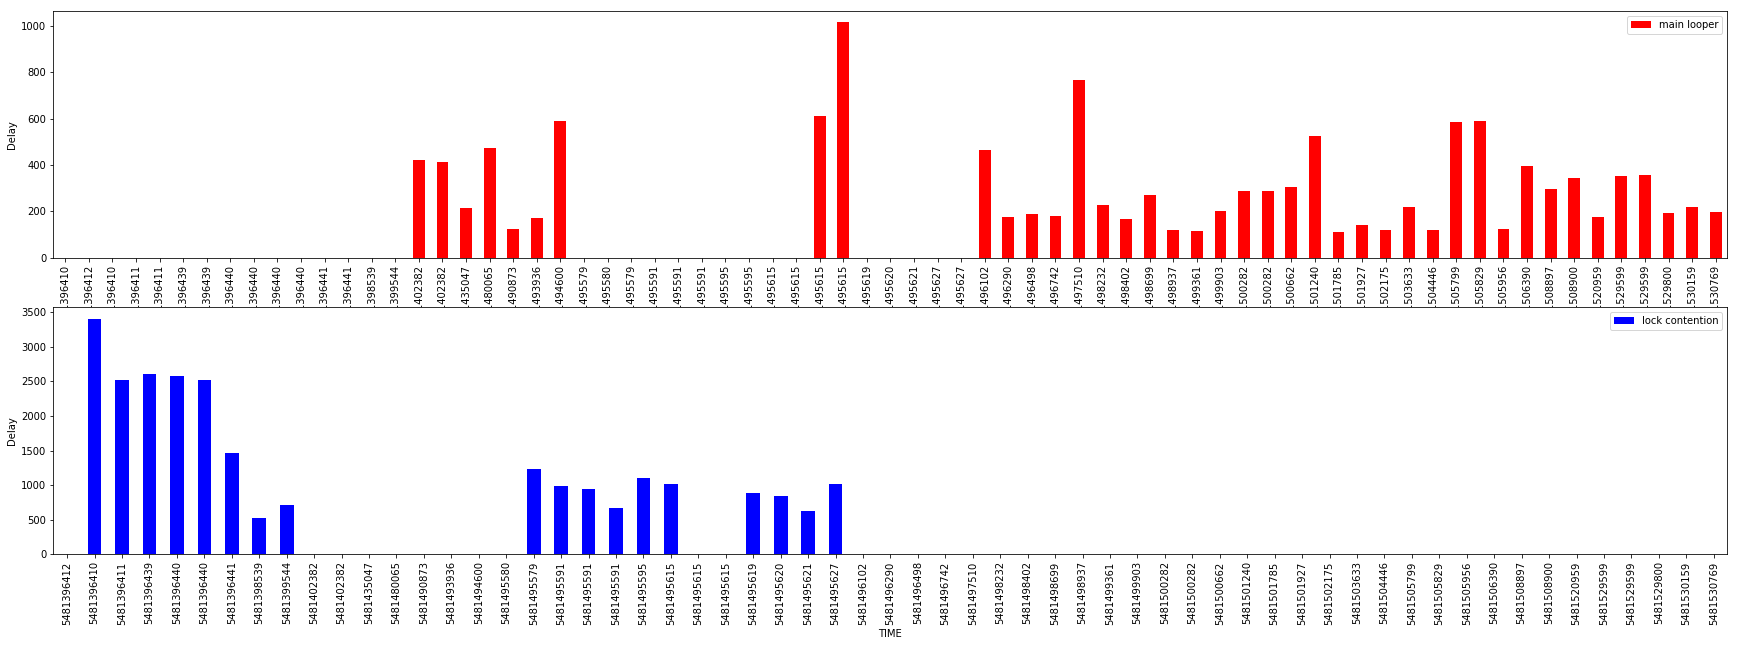

In [162]:
#df = pd.DataFrame(bottleneck_hints)
df_mainl = pd.DataFrame(mainl)
df_lockc = pd.DataFrame(lockc)
#df_inputd = pd.DataFrame(inputd)
df_pisio = pd.DataFrame(pisio)
df_bhint = pd.DataFrame(bottleneck_hints)
#df_bhint['AVG'] = df_bhint['AVG'] * (-1)
#print(df_bhint['AVG'])

fig, axs = plt.subplots(2)
#ax2 = ax1.twinx()

#ax2.text(1,1500, 'v')
#df_bhint.plot(x='TIME', y='AVG', kind='bar', ax=ax2, color='green', label='bottleneck hint', figsize=(30,5), legend=True)
df_mainl.plot(x='TIME', y='took', kind='bar', ax=axs[0], color='red', label='main looper', figsize=(30,10), legend=True)
df_lockc.plot(x='TIME', y='/', kind='bar', ax=axs[1], color='blue', label='lock contention', figsize=(30,10), legend=True)
#df_inputd.plot(x='TIME', y='TOTAL_DELAY', ax=ax2, color='purple', label='input delay', figsize=(30,5), legend=True)
axs[0].legend(loc=0)
axs[1].legend(loc=0)
axs[0].set_ylabel('Delay')
axs[1].set_ylabel('Delay')

#for bottleneck_hint in bottleneck_hints['TIME']:
#    plt.axvline(x=int(bottleneck_hint), color='lime', linestyle='--', alpha=0.3)

#count=0
#for bottleneck_hint in bottleneck_hints['AVG']:
#    if bottleneck_hint > 0 :
#        ax2.text(count,5000, 'o', color='green')
#    count += 1

#plt.axvline(x=29009117939, color='red', linestyle='--')
    
#plt.grid(True)
plt.show()

In [163]:
BOTTLENECK_INPUT = {'INPUTD':[], 'LOCKC':[], 'MAINL':[]}
BOTTLENECK = list()
BOTTLENECK_HINT = list()
EMPTY_INPUT = 'ID=EMPTY DELAY=0 WIN=0'
EMPTY = 'ID=EMPTY WIN=0 AVG=0'
EMPTY_HINT = 'ID=EMPTY WIN=0 AVG=10'

for olog_line in olog_lines:
    time = GetTime(olog_line)
    if 'INPUTD' in olog_line:
        BOTTLENECK_INPUT['INPUTD'].append('TIME={} {}'.format(time, olog_line))
    elif 'LOCKCONTENTION' in olog_line:
        BOTTLENECK_INPUT['LOCKC'].append('TIME={} {}'.format(time, olog_line))
    elif 'MAINLOOPER' in olog_line:
        BOTTLENECK_INPUT['MAINL'].append('TIME={} {}'.format(time, olog_line))
        
    if '[BOTTLENECK_HINT]  HINT ON' in olog_line:
        BOTTLENECK_HINT.append('TIME={} {}'.format(time, EMPTY_HINT))

inputd = DictFromPickedUp(BOTTLENECK_INPUT['INPUTD'], {'TIME':0, 'TOTAL_DELAY':0})
lockc = DictFromPickedUp(BOTTLENECK_INPUT['LOCKC'], {'TIME':0, '/':0})
mainl = DictFromPickedUp(BOTTLENECK_INPUT['MAINL'], {'TIME':0, 'took':0})
#bottleneck = DictFromPickedUp(BOTTLENECK, {'TIME':0, 'WIN':0, 'AVG':0})
bottleneck_hints = DictFromPickedUp(BOTTLENECK_HINT, {'TIME':0, 'WIN':0, 'AVG':0})

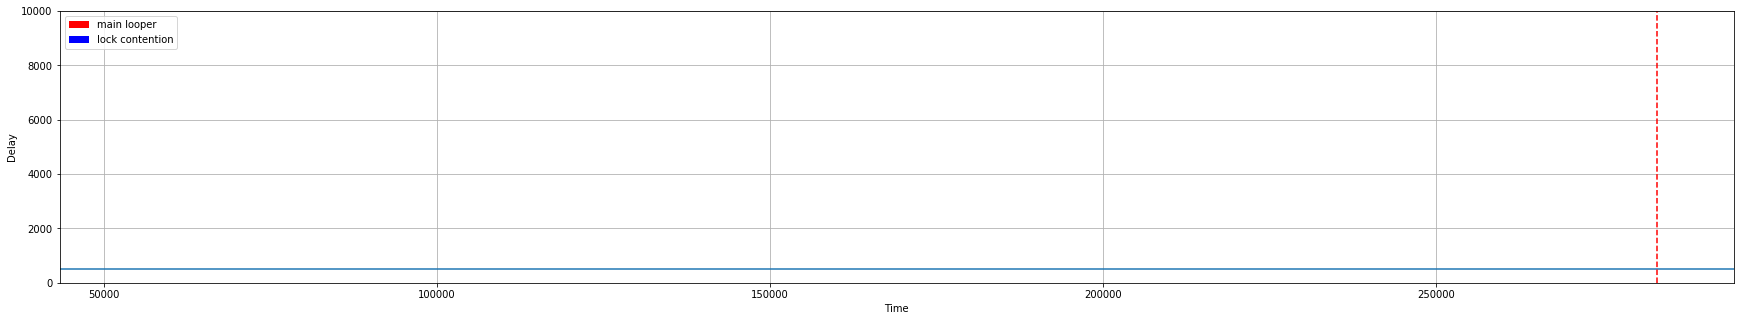

In [164]:
time_scale = 100000.0
#df = pd.DataFrame(bottleneck_hints)
df_mainl = pd.DataFrame(mainl)
df_lockc = pd.DataFrame(lockc)
df_inputd = pd.DataFrame(inputd)
df_pisio = pd.DataFrame(pisio)
df_bhint = pd.DataFrame(bottleneck_hints)

df_mainl['TIME'] = df_mainl['TIME'] / time_scale + 2
df_lockc['TIME'] = df_lockc['TIME'] / time_scale
df_inputd['TIME'] = df_inputd['TIME'] / time_scale + 2
df_pisio['TIME'] = df_pisio['TIME'] / time_scale
df_bhint['TIME'] = df_bhint['TIME'] / time_scale
df_bhint['AVG'] = df_bhint['AVG'] * (-20)

#display(df_inputd)

plt.figure(figsize=(30,5))
if len(df_mainl) > 0:
    plt.bar(df_mainl['TIME'], df_mainl['took'], color='red', label='main looper')
if len(df_lockc) > 0:
    plt.bar(df_lockc['TIME'], df_lockc['/'], color='blue', label='lock contention')
if len(df_inputd) > 0:
    plt.bar(df_inputd['TIME'], df_inputd['TOTAL_DELAY'], color='purple', label='input delay')
if len(df_pisio) > 0:
    plt.scatter(df_pisio['TIME'], df_pisio['avg10'], color='green', label='psi')
#if len(df_bhint) > 0:
#    plt.scatter(df_bhint['TIME'],df_bhint['AVG'], marker='^', label='bottleneck hint (> 500 ms)')
plt.axhline(500)
plt.axvline(int(28323279717 / time_scale) - 1, color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Delay')
plt.ylim(0,10000)
plt.legend()
plt.grid()
plt.show()

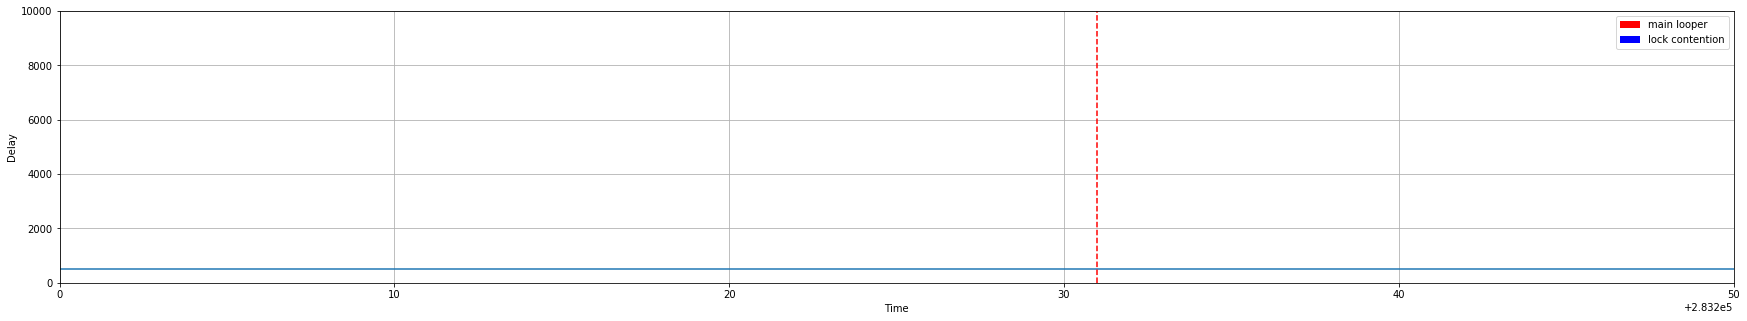

In [165]:
time_scale = 100000.0
#df = pd.DataFrame(bottleneck_hints)
df_mainl = pd.DataFrame(mainl)
df_lockc = pd.DataFrame(lockc)
df_inputd = pd.DataFrame(inputd)
df_pisio = pd.DataFrame(pisio)
df_bhint = pd.DataFrame(bottleneck_hints)

df_mainl['TIME'] = df_mainl['TIME'] / time_scale + 2
df_lockc['TIME'] = df_lockc['TIME'] / time_scale
df_inputd['TIME'] = df_inputd['TIME'] / time_scale + 2
df_pisio['TIME'] = df_pisio['TIME'] / time_scale
df_pisio['avg10'] = df_pisio['avg10'] * 100.0
df_bhint['TIME'] = df_bhint['TIME'] / time_scale
df_bhint['AVG'] = df_bhint['AVG'] * (-20)

#display(df_inputd)

plt.figure(figsize=(30,5))
if len(df_mainl) > 0:
    plt.bar(df_mainl['TIME'], df_mainl['took'], color='red', label='main looper')
if len(df_lockc) > 0:
    plt.bar(df_lockc['TIME'], df_lockc['/'], color='blue', label='lock contention')
if len(df_inputd) > 0:
    plt.bar(df_inputd['TIME'], df_inputd['TOTAL_DELAY'], color='purple', label='input delay')
if len(df_pisio) > 0:
    plt.plot(df_pisio['TIME'], df_pisio['avg10'], color='green', label='psi')
#if len(df_bhint) > 0:
#    plt.scatter(df_bhint['TIME'],df_bhint['AVG'], marker='^', label='bottleneck hint (> 500 ms)')
plt.axhline(500)
plt.axvline(int(28323279717 / time_scale) - 1, color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Delay')
plt.ylim(0,10000)
plt.xlim(283200,283250)
plt.legend()
plt.grid()
plt.show()

In [166]:
lines = lp.log_sections['beginning of main']
display(lines)
olog_lines = grep(lines,['Looper  : Slow', 'Long monitor contention', 'BOTTLENECK_HINT'], 1)

[]

--- Nothing ---


In [167]:
BOTTLENECK_INPUT = {'INPUTD':[], 'LOCKC':[], 'MAINL':[]}
BOTTLENECK = list()
BOTTLENECK_HINT = list()
EMPTY_INPUT = 'ID=EMPTY DELAY=0 WIN=0'
EMPTY = 'ID=EMPTY WIN=0 AVG=0'
EMPTY_HINT = 'ID=EMPTY WIN=0 AVG=10'

for olog_line in olog_lines:
    time = GetTime(olog_line)
    if 'INPUTD' in olog_line:
        BOTTLENECK_INPUT['INPUTD'].append('TIME={} {}'.format(time, olog_line))
    elif 'LOCKCONTENTION' in olog_line:
        BOTTLENECK_INPUT['LOCKC'].append('TIME={} {}'.format(time, olog_line))
    elif 'MAINLOOPER' in olog_line:
        BOTTLENECK_INPUT['MAINL'].append('TIME={} {}'.format(time, olog_line))
        
    if '[BOTTLENECK_HINT]  HINT ON' in olog_line:
        BOTTLENECK_HINT.append('TIME={} {}'.format(time, EMPTY_HINT))

inputd = DictFromPickedUp(BOTTLENECK_INPUT['INPUTD'], {'TIME':0, 'TOTAL_DELAY':0})
lockc = DictFromPickedUp(BOTTLENECK_INPUT['LOCKC'], {'TIME':0, '/':0})
mainl = DictFromPickedUp(BOTTLENECK_INPUT['MAINL'], {'TIME':0, 'took':0})
#bottleneck = DictFromPickedUp(BOTTLENECK, {'TIME':0, 'WIN':0, 'AVG':0})
bottleneck_hints = DictFromPickedUp(BOTTLENECK_HINT, {'TIME':0, 'WIN':0, 'AVG':0})